In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.visualization import plot_histogram

from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_aer import QasmSimulator, AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer.noise.errors import depolarizing_error

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime.noise_learner import NoiseLearner
from qiskit_ibm_runtime.options import NoiseLearnerOptions

from sympy import symbols, Xor, And, lambdify
import random, copy
from numpy import angle, exp as np
import matplotlib
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power 
import time
import pandas as pd
import logging
%run che_bfv.ipynb
import logging
# Set Matplotlib's logging level to INFO (or higher, like WARNING)
logging.getLogger('matplotlib').setLevel(logging.INFO)

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def run_bfv_tests(mod_value=2, test_iterations=3):
    """
    Run homomorphic encryption tests for the BFV scheme.

    Args:
        mod_value (int): Modulo value for arithmetic (default: 2 for binary).
        test_iterations (int): Number of iterations for multiple addition test (default: 3).

    Returns:
        dict: Test results with test names and pass/fail status.
    """
    results = {}
    try:
        # Initialize CHE components
        params, encoder, encryptor, decryptor, evaluator = initialize_bfv_params()
        poly_degree = params.poly_degree
        logger.info(f"Initialized with polynomial degree: {poly_degree}")

        def encode_value(value, length):
            """Encode a value into a padded list for encryption."""
            return encoder.encode([value] + [0] * (length - 1))

        # Test 1: Encoding and decoding
        value = 1
        try:
            encoded = encode_value(value, poly_degree)
            encrypted = encryptor.encrypt(encoded)
            decrypted = decryptor.decrypt(encrypted)
            decoded = encoder.decode(decrypted)[0] % mod_value
            results['test_encoding_decoding'] = decoded == value
            logger.info(f"Test 1: Input {value}, Decoded {decoded}, {'Pass' if decoded == value else 'Fail'}")
        except Exception as e:
            logger.error(f"Test 1 failed: {str(e)}")
            results['test_encoding_decoding'] = False

        # Test 2: Homomorphic addition (1 + 1 = 0 mod 2)
        try:
            enc_1 = encryptor.encrypt(encode_value(1, poly_degree))
            enc_1_again = encryptor.encrypt(encode_value(1, poly_degree))
            sum_enc = evaluator.add(enc_1, enc_1_again)
            sum_decoded = encoder.decode(decryptor.decrypt(sum_enc))[0] % mod_value
            expected = (1 + 1) % mod_value
            results['test_homomorphic_addition'] = sum_decoded == expected
            logger.info(f"Test 2: 1 + 1 = {sum_decoded} mod {mod_value}, {'Pass' if sum_decoded == expected else 'Fail'}")
        except Exception as e:
            logger.error(f"Test 2 failed: {str(e)}")
            results['test_homomorphic_addition'] = False

        # Test 3: Multiple additions
        try:
            enc_0 = encryptor.encrypt(encode_value(0, poly_degree))
            enc_sum = encryptor.encrypt(encode_value(1, poly_degree))
            for _ in range(test_iterations):
                enc_sum = evaluator.add(enc_sum, enc_0)
            final_decoded = encoder.decode(decryptor.decrypt(enc_sum))[0] % mod_value
            results['test_multiple_additions'] = final_decoded == 1
            logger.info(f"Test 3: 1 + {'0 + ' * (test_iterations - 1)}0 = {final_decoded} mod {mod_value}, {'Pass' if final_decoded == 1 else 'Fail'}")
        except Exception as e:
            logger.error(f"Test 3 failed: {str(e)}")
            results['test_multiple_additions'] = False

        return results

    except Exception as e:
        logger.error(f"Initialization failed: {str(e)}")
        return {'initialization': False}

if __name__ == "__main__":
    test_results = run_bfv_tests()
    logger.info(f"Test Results: {test_results}")

2025-09-09 14:56:48,927 - INFO - Initialized with polynomial degree: 8
2025-09-09 14:56:48,928 - INFO - Test 1: Input 1, Decoded 1, Pass
2025-09-09 14:56:48,928 - INFO - Test 2: 1 + 1 = 0 mod 2, Pass
2025-09-09 14:56:48,929 - INFO - Test 3: 1 + 0 + 0 + 0 = 1 mod 2, Pass
2025-09-09 14:56:48,929 - INFO - Test Results: {'test_encoding_decoding': True, 'test_homomorphic_addition': True, 'test_multiple_additions': True}


In [3]:
# Save your API key to track your progress and have access to the quantum computers

your_api_key = "_E9_63Zvy4O9kGPlYGzAzKl4I7yhlzDi_JEYVuP80hkw"
your_crn = "crn:v1:bluemix:public:quantum-computing:us-east:a/6773dfcbdff44648bba3f1257a8072c3:c64c8982-d882-47c7-a6fc-c4d3f8a57872::"

from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=your_api_key,
    instance=your_crn,
    name="qgss-2025",
    overwrite=True
)

# Check that the account has been saved properly
service = QiskitRuntimeService(name="qgss-2025")
service.saved_accounts()

{'DNA-Alignment': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': '_E9_63Zvy4O9kGPlYGzAzKl4I7yhlzDi_JEYVuP80hkw',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/6773dfcbdff44648bba3f1257a8072c3:c64c8982-d882-47c7-a6fc-c4d3f8a57872::',
  'verify': True,
  'private_endpoint': False},
 'GiaDang': {'channel': 'ibm_cloud',
  'url': 'https://cloud.ibm.com',
  'token': 'eHc1OpTrwz8rYRBQVTArP_6BxOlVBDN43G-RF9l8bkXz',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/6773dfcbdff44648bba3f1257a8072c3:c64c8982-d882-47c7-a6fc-c4d3f8a57872:',
  'verify': True,
  'private_endpoint': False},
 'Gia_Dang': {'channel': 'ibm_cloud',
  'url': 'https://cloud.ibm.com',
  'token': 'ivT3H3kmsl7JhhpGtg0b73K-urCzXxDS0EW7zjRXK0Rg',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/6773dfcbdff44648bba3f1257a8072c3:4e75aa33-de8b-43da-9bd2-e4b51fa1c6d7::',
  'verify': True,
  'private_endpoint': False},
 'default-ibm-cloud': {'channel'

In [4]:
# Define the service. This allows you to access IBM QPUs.
service = QiskitRuntimeService(name="qgss-2025")

# Get a backend
backend = service.least_busy(operational=True, simulator=False)
print(f"We are using the {backend.name} quantum computer")

We are using the ibm_torino quantum computer


In [5]:
print(backend.name)
print(backend.configuration().simulator)  # True = simulator, False = real hardware
print(backend.configuration().n_qubits)
print(backend.status().operational)

ibm_torino
False
133
True


In [5]:
import logging
import time
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
import random

# Configure logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def aux_keygen(num_qubits, t_depth, a_init, b_init, t_positions):
    """
    Generate keys and auxiliary states for AUX-QHE scheme with FHE.

    Args:
        num_qubits (int): Number of qubits.
        t_depth (int): Maximum T-depth.
        a_init (list): Initial QOTP X-keys.
        b_init (list): Initial QOTP Z-keys.
        t_positions (list): List of T-gate counts per qubit.

    Returns:
        tuple: (secret_key, aux_states, prep_time, layer_sizes, total_aux_states)
            - secret_key: (a_init, b_init, k_dict) where k_dict maps (i, l) to k values.
            - aux_states: Dict mapping (i, l, term) to (QuantumCircuit, k_value).
            - prep_time: Time taken for preparation.
            - layer_sizes: List of |T_ell| for each layer.
            - total_aux_states: Total number of auxiliary states.
    """
    try:
        aux_prep_start = time.perf_counter()

        # Initialize T_ell layers for monomials
        T = [None] * (t_depth + 1)  # T[1] to T[t_depth]
        T[1] = [f"a{i}_0" for i in range(num_qubits)] + [f"b{i}_0" for i in range(num_qubits)]

        # Construct T_ell for ell = 2 to t_depth
        for layer in range(2, t_depth + 1):
            prev = layer - 1
            # New variables k_{i,j}_layer{l-1}
            new_vars = [f"k_{i}_{j}_layer{prev}" for i in range(num_qubits) for j in range(len(T[prev]))]
            # Cross-terms: t * t' for t, t' in T[l-1], t ≠ t'
            cross_terms = [f"{t1}*{t2}" for i, t1 in enumerate(T[prev]) for t2 in T[prev][i+1:]]
            T[layer] = T[prev] + cross_terms + new_vars

        # Collect per-layer sizes
        layer_sizes = [len(T[ell]) for ell in range(1, t_depth + 1)]
        total_aux_states = sum(num_qubits * len(T[ell]) for ell in range(1, t_depth + 1))

        # Generate auxiliary states for T-gates
        aux_states = {}
        k_dict = {}
        for ell in range(1, t_depth + 1):
            for i in range(num_qubits):
                for term in T[ell]:  # All terms in T_ell
                    qc = QuantumCircuit(1, name=f'aux_{i}_{term}_layer{ell}')
                    qc.h(0)
                    qc.t(0)
                    qc.t(0)  # T^2 for |A⟩ = |0⟩ + e^(iπ/2)|1⟩ / √2
                    # Apply X only for a_i terms matching a_init
                    if term.startswith('a') and term == f'a{i}_0' and a_init[i]:
                        qc.x(0)
                    k_value = random.randint(0, 1)
                    if k_value:
                        qc.z(0)
                    aux_states[(i, ell-1, str(term))] = (qc, k_value)
                    k_dict[(i, ell-1, str(term))] = k_value
                    #logger.debug(f"Generated aux state for qubit {i}, layer {ell}, term {term}: k={k_value}")
        
        aux_prep_time = time.perf_counter() - aux_prep_start
        logger.info(f"AUX key generation completed: {total_aux_states} aux states, prep_time={aux_prep_time:.4f}s")
        return (a_init, b_init, k_dict), aux_states, aux_prep_time, layer_sizes, total_aux_states
    
    except Exception as e:
        logger.error(f"AUX key generation failed: {str(e)}")
        raise

In [6]:
# Configure logging at root level to ensure DEBUG logs
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().handlers = [logging.StreamHandler()]
logger = logging.getLogger(__name__)

def qotp_encrypt(circuit, a_keys, b_keys, d, n, encryptor, encoder, decryptor, poly_degree):
    """
    Encrypt a quantum circuit using QOTP with FHE.

    Args:
        circuit (QuantumCircuit): Input circuit.
        a_keys, b_keys (list): QOTP key lists.
        d (int): Key offset.
        n (int): Total qubits.
        encryptor: BFV encryptor.
        encoder: BFV encoder.
        decryptor: BFV decryptor.
        poly_degree (int): Polynomial degree.

    Returns:
        tuple: (Encrypted circuit, updated d, enc_a, enc_b) or (None, d, None, None) if qubit bound exceeded.
    """
    # Log logger level for diagnostics
    logger.debug(f"qotp_encrypt logger level: {logger.getEffectiveLevel()}")
    
    # Check qubit bound
    if d + circuit.num_qubits > n:
        logger.debug(f"QOTP encryption failed: qubit bound exceeded (d={d}, num_qubits={circuit.num_qubits}, n={n})")
        return None, d, None, None
    
    # Create a new circuit to ensure correct gate order
    qr = QuantumRegister(circuit.num_qubits, 'q')
    enc_circuit = QuantumCircuit(qr)
    # Copy main circuit gates
    for instr in circuit.data:
        enc_circuit.append(instr.operation, instr.qubits)
    
    # Multi-value BFV test for key encoding/decoding
    try:
        test_vals = a_keys[d:d+circuit.num_qubits]  # Test with a subset of keys
        if len(test_vals) > 0:
            encoded = encoder.encode(test_vals + [0] * (poly_degree - len(test_vals)))
            encrypted = encryptor.encrypt(encoded)
            dec_vals = encoder.decode(decryptor.decrypt(encrypted))
            logger.debug(f"Multi-value test: input={test_vals}, encoded={encoded}, decrypted={dec_vals}")
            if any(abs(dec_vals[i] - test_vals[i]) > 1e-6 for i in range(len(test_vals))):
                logger.warning(f"Non-binary decrypted values in multi-value test: input={test_vals}, decrypted={dec_vals}")
    except Exception as e:
        logger.error(f"Multi-value test failed: {str(e)}")
    
    # Append QOTP gates after main gates
    enc_a = []
    enc_b = []
    logger.debug(f"Encrypting circuit with a_keys={a_keys[d:d+circuit.num_qubits]}, b_keys={b_keys[d:d+circuit.num_qubits]}")
    for i in range(circuit.num_qubits):
        if a_keys[d + i]:
            enc_circuit.x(i)
        if b_keys[d + i]:
            enc_circuit.z(i)
        
        # Encode and encrypt keys with debug logging
        a_encoded = encoder.encode([a_keys[d + i]] + [0] * (poly_degree - 1))
        b_encoded = encoder.encode([b_keys[d + i]] + [0] * (poly_degree - 1))
        logger.debug(f"QOTP key a_{i}: input={a_keys[d + i]}, encoded={a_encoded}")
        logger.debug(f"QOTP key b_{i}: input={b_keys[d + i]}, encoded={b_encoded}")
        
        enc_a.append(encryptor.encrypt(a_encoded))
        enc_b.append(encryptor.encrypt(b_encoded))
        
        # Immediately decrypt to verify correctness
        try:
            a_dec_raw = encoder.decode(decryptor.decrypt(enc_a[-1]))[0]
            b_dec_raw = encoder.decode(decryptor.decrypt(enc_b[-1]))[0]
            logger.debug(f"QOTP key a_{i}: encrypted, decrypted raw={a_dec_raw}, expected={a_keys[d + i]}")
            logger.debug(f"QOTP key b_{i}: encrypted, decrypted raw={b_dec_raw}, expected={b_keys[d + i]}")
            if abs(a_dec_raw - a_keys[d + i]) > 1e-6 or abs(b_dec_raw - b_keys[d + i]) > 1e-6:
                logger.warning(f"Decryption mismatch in qotp_encrypt for qubit {i}: a_raw={a_dec_raw}, b_raw={b_dec_raw}, expected a={a_keys[d + i]}, b={b_keys[d + i]}")
        except Exception as e:
            logger.error(f"Immediate decryption failed for qubit {i} in qotp_encrypt: {str(e)}")
    
    d = (d + circuit.num_qubits) % (n - circuit.num_qubits + 1)
    logger.info(f"QOTP encryption applied, d updated to {d}")
    logger.debug(f"Encrypted circuit instructions: {[instr.operation.name for instr in enc_circuit.data]}")
    logger.debug(f"Encrypted circuit state: {Statevector(enc_circuit)}")
    return enc_circuit, d, enc_a, enc_b

In [7]:
def qotp_decrypt(circuit, enc_a, enc_b, decryptor, encoder, poly_degree):
    """
    Decrypt a QOTP-encrypted circuit for AUX-QHE.

    Args:
        circuit (QuantumCircuit): Encrypted quantum circuit.
        enc_a (list): Encrypted a keys.
        enc_b (list): Encrypted b keys.
        decryptor: BFV decryptor from che_initialization.
        encoder: BFV encoder from che_initialization.
        poly_degree (int): Polynomial degree for BFV decoding.

    Returns:
        QuantumCircuit: Decrypted circuit.
    """
    decrypted_circuit = circuit.copy()
    logger.debug(f"Decrypting circuit with {len(enc_a)} encrypted keys")
    for i in range(circuit.num_qubits):
        try:
            # Decrypt and decode keys
            raw_a = encoder.decode(decryptor.decrypt(enc_a[i]))[0]
            raw_b = encoder.decode(decryptor.decrypt(enc_b[i]))[0]
            logger.debug(f"Decrypting qubit {i}: raw_a={raw_a}, raw_b={raw_b}")

            # Validate for non-binary values
            if not (abs(raw_a - round(raw_a)) < 1e-6 and round(raw_a) in [0, 1]):
                logger.warning(f"Non-binary decrypted value detected in qotp_decrypt for a_{i}: {raw_a}, expected binary (0 or 1)")
            if not (abs(raw_b - round(raw_b)) < 1e-6 and round(raw_b) in [0, 1]):
                logger.warning(f"Non-binary decrypted value detected in qotp_decrypt for b_{i}: {raw_b}, expected binary (0 or 1)")

            # Sanitize values
            a_val = int(round(raw_a)) % 2
            b_val = int(round(raw_b)) % 2
            logger.debug(f"Sanitized qubit {i}: a_val={a_val}, b_val={b_val}, raw_a={raw_a}, raw_b={raw_b}")

            # Apply X^a Z^b (reverse order of encryption)
            if b_val:
                decrypted_circuit.z(i)
            if a_val:
                decrypted_circuit.x(i)
        except Exception as e:
            logger.error(f"Decryption failed for qubit {i} in qotp_decrypt: {str(e)}")
            raise
    
    logger.debug(f"Decrypted circuit instructions: {[instr.operation.name for instr in decrypted_circuit.data]}")
    logger.debug(f"Decrypted circuit state: {Statevector(decrypted_circuit)}")
    return decrypted_circuit

In [ ]:
# Configure logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def tcl_layers(operations):
    """
    Organize operations into T and Clifford layers.
    
    Args:
        operations (list): List of (gate, qubit(s)) tuples.
    
    Returns:
        tuple: (layers, t_depth).
    """
    try:
        layers = []
        t_layers = 0
        current = []
        used = set()
        for op in operations:
            gate, q = op
            logger.debug(f"Processing operation: gate={gate}, qubits={q}")
            qlist = q if isinstance(q, (list, tuple)) else [q]
            if any(x in used for x in qlist):
                if any(g == 't' for g, _ in current):
                    t_layers += 1
                layers.append(current)
                current = []
                used.clear()
            current.append(op)
            used.update(qlist)
        if current:
            if any(g == 't' for g, _ in current):
                t_layers += 1
            layers.append(current)
        logger.info(f"Organized {len(operations)} operations into {len(layers)} layers, T-depth={t_layers}")
        return layers, t_layers
    except Exception as e:
        logger.error(f"Failed to organize layers: {str(e)}")
        raise

def resolve_expr(expr, symbolic_var, prefix, idx):
    if expr is None:
        return None
    var_map = {str(k): v for k, v in symbolic_var.items()}
    missing_vars = [str(sym) for sym in expr.free_symbols if str(sym) not in var_map]
    if missing_vars:
        logger.error(f"Unresolved symbols in {prefix}_{idx}: {missing_vars}, expr={expr}, var_map={var_map}")
        raise TypeError(f"Cannot convert symbols to int: {missing_vars}")
    func = lambdify(list(var_map.keys()), expr, modules='numpy')
    result = int(func(*var_map.values())) % 2
    logger.debug(f"Resolved {prefix}_{idx}: {expr} -> {result}")
    return result



def combine_aux_states(term_keys, aux_states, qregs, qubit, t_idx, symbolic_vars, num_qubits, debug=False):
    """
    Combine auxiliary states to construct |+_{f_{a,i},k}> for T-gadget.
    
    Args:
        term_keys: List of (qubit, t_idx, term) for terms in f_{a,i}.
        aux_states: Dictionary of auxiliary states.
        qregs: Quantum registers of the circuit.
        qubit: Qubit index for T-gate.
        t_idx: T-gate index.
        symbolic_vars: List of dictionaries mapping symbols to values.
        debug: Boolean for debug logging.
    
    Returns:
        tuple: (combined_circuit, k_value, c_values)
    """
    if len(term_keys) == 1:
        # Single term: use directly
        aux_circuit, k_value = aux_states[term_keys[0]]
        if debug:
            logger.debug(f"Single term for qubit {qubit}, T-gate {t_idx}: term={term_keys[0][2]}, k={k_value}")
        return aux_circuit, k_value, []
    
    # Validate qubit index
    if qubit >= num_qubits:
        raise ValueError(f"Qubit index {qubit} exceeds num_qubits {num_qubits}")

    # Initialize circuit with auxiliary qubits
    aux_qubits_needed = len(term_keys)
    aux_reg = QuantumRegister(aux_qubits_needed, f"aux_{qubit}_{t_idx}")
    comb_circuit = QuantumCircuit(aux_reg, ClassicalRegister(aux_qubits_needed-1, f"comb_meas_{qubit}_{t_idx}"))
    
    # Initialize auxiliary states
    k_values = []
    for i, key in enumerate(term_keys):
        aux_circuit, k_i = aux_states[key]
        comb_circuit.compose(aux_circuit, qubits=[aux_reg[i]], inplace=True)
        k_values.append(k_i)
    
    # Combine states pairwise
    c_values = []
    current_qubit = 0  # Output qubit index
    for i in range(1, len(term_keys)):
        comb_circuit.cx(aux_reg[current_qubit], aux_reg[i])
        comb_circuit.h(aux_reg[i])
        comb_circuit.measure(aux_reg[i], i-1)
        c_values.append(f'c_comb_{qubit}_{t_idx}_{i}')
        current_qubit = i if i == len(term_keys)-1 else current_qubit
    
    #Simulate measurement (same as T-gadget)
    #simulator = AerSimulator(method='statevector')
    #simulator = backend
    #result = simulator.run(comb_circuit, shots=1000).result()
    #counts = result.get_counts()
    #c_measured = [1 if counts.get('1' * (i+1), 0) > counts.get('0' * (i+1), 0) else 0 for i in range(len(c_values))]
    pass_manager = generate_preset_pass_manager(optimization_level=0, backend=backend)
    transpiled_aux = pass_manager.run(comb_circuit)
    sampler = Sampler(mode=backend)
    job = sampler.run([(transpiled_aux, None)], shots=4096)
    result = job.result()
    counts = result[0].data[f"comb_meas_{qubit}_{t_idx}"].get_counts()
    c_measured = [1 if counts.get('1' * (i+1), 0) > counts.get('0' * (i+1), 0) else 0 for i in range(len(c_values))]
    
    # Compute combined k
    k_value = k_values[0]
    for i in range(1, len(k_values)):
        k_value ^= k_values[i]
        # Resolve term value using symbolic_vars
        term = term_keys[i][2]  # e.g., 'a1_0'
        term_value = symbolic_vars[qubit].get(term, 0)  # Default to 0 if unresolved
        k_value ^= c_measured[i-1] * term_value
        if debug:
            logger.debug(f"Term {term}: value={term_value}, c_measured[{i-1}]={c_measured[i-1]}")

    # Cross-terms (simplified for implementation)
    for i in range(len(term_keys)):
        for j in range(i+1, len(term_keys)):
            term_i = term_keys[i][2]
            term_j = term_keys[j][2]
            value_i = symbolic_vars[qubit].get(term_i, 0)
            value_j = symbolic_vars[qubit].get(term_j, 0)
            k_value ^= value_i * value_j
            if debug:
                logger.debug(f"Cross-term {term_i}*{term_j}: value={value_i * value_j}")

    # Extract circuit for final state (exclude measurements)
    final_circuit = QuantumCircuit(1, name=f'combined_aux_{qubit}_{t_idx}')
    for instr in comb_circuit.data:
        if instr.qubits[0] == aux_reg[current_qubit] and instr.operation.name != 'measure':
            final_circuit.append(instr.operation, [final_circuit.qubits[0]])
    
    if debug:
        logger.debug(f"Combined {len(term_keys)} auxiliary states for qubit {qubit}, T-gate {t_idx}: k={k_value}")
        logger.debug(f"comb_circuit registers: {comb_circuit.qregs}, clbits: {len(comb_circuit.clbits)}")
        logger.debug(f"final_circuit registers: {final_circuit.qregs}, clbits: {len(final_circuit.clbits)}")
    
    return final_circuit, k_value, c_measured

def update_keys_for_single_qubit_gate(circuit, gate, qubit, a_temp, b_temp, a_expr, b_expr, symbolic_vars, t_gate_counters, aux_states, debug=True):

    """
    Update keys for single-qubit gates (H, T).

    Args:
        circuit (QuantumCircuit): Circuit to modify.
        gate (str): Gate name ('h', 'x', 'z', 't').
        qubit (int): Qubit index.
        a_temp, b_temp (list): Current QOTP keys.
        a_expr, b_expr (list): Symbolic key expressions.
        symbolic_vars (list): Variable mappings per qubit.
        t_gate_counters (list): T-gate counters per qubit.
        aux_states (dict): Auxiliary states {(qubit, t_index, term): (circuit, k_value)}.
        debug (bool): Enable debug logging.

    Returns:
        tuple: Updated (a_temp, b_temp, a_expr, b_expr, symbolic_vars).
    """
    try:
        # Check if gate is already in circuit to avoid reapplication
        
        t_gadget_time = 0.0
        t_time = 0.0  # Initialize t_time for all gates
        #key_log = [] if debug else None

        # check is already applied
        gate_exists = any(instr.operation.name == gate and circuit.qubits.index(instr.qubits[0]) == qubit 
                          for instr in circuit.data)
        if gate_exists:
            if debug:
                logger.debug(f"Gate {gate} already applied on qubit {qubit}, skipping")
            return a_temp, b_temp, a_expr, b_expr, symbolic_vars, t_gadget_time, t_time
        
        # Handle single-qubit gates
        if gate == 'h' and not gate_exists:
            # swap a and b keys for H gate
            a_temp[qubit], b_temp[qubit] = b_temp[qubit], a_temp[qubit]
            circuit.h(qubit)
            if debug:
                logger.debug(f"Applied H on qubit {qubit}: a={a_temp[qubit]}, b={b_temp[qubit]}")

        elif gate == 'x':
            circuit.x(qubit)
            if debug:
                logger.debug(f"Applied X on qubit {qubit}: a={a_temp[qubit]}, b={b_temp[qubit]}")

        elif gate == 'z':
            circuit.z(qubit)
            if debug:
                logger.debug(f"Applied Z on qubit {qubit}: a={a_temp[qubit]}, b={b_temp[qubit]}")

        elif gate == 't':
            # increment T-gate counter
            t_idx = t_gate_counters[qubit]
            t_gate_counters[qubit] += 1

            # Initialize a_expr if None
            if a_expr[qubit] is None:
                a_expr[qubit] = Symbol(f'a{qubit}_0')
                symbolic_vars[qubit][f'a{qubit}_0'] = a_temp[qubit]

            f_a_i = a_expr[qubit]
            terms = f_a_i.args if f_a_i.func == Xor else (f_a_i,)
            term_keys = [(qubit, t_idx, str(term)) for term in terms]
            if debug:
                logger.debug(f"T-gate terms for qubit {qubit}: {terms}")

            # Validate auxiliary states
            for term_key in term_keys:
                if term_key not in aux_states:
                    logger.error(f"No auxiliary state for term {term_key} in T-gate {t_idx} on qubit {qubit}")
                    raise ValueError(f"No auxiliary state for term {term_key}")
                
            # Combine auxiliary states to get |+_{f_{a,i},k}>
            start_time = time.time()
            combined_circuit, k_value, c_values = combine_aux_states(
                term_keys, aux_states, circuit.qregs, qubit, t_idx, symbolic_vars, circuit.num_qubits, debug
            )
            comb_time = time.time() - start_time

            # Create T-gadget circuit with data and auxiliary qubits
            data_reg = circuit.qregs[0]  # Assume first register is data qubits
            aux_reg = QuantumRegister(1, f"aux_{qubit}_{t_idx}")
            circ_aux = QuantumCircuit(data_reg, aux_reg, ClassicalRegister(1, f"meas_aux_{qubit}_{t_idx}"))
            circ_aux.compose(combined_circuit, qubits=[aux_reg[0]], inplace=True)  # Map to auxiliary qubit
            circ_aux.cx(data_reg[qubit], aux_reg[0])  # Data qubit to auxiliary
            circ_aux.h(aux_reg[0])
            circ_aux.measure(aux_reg[0], 0)

            # Simulate T-gadget
            start_time = time.time()  # Your timing method
            #simulator = AerSimulator(method='statevector')
            #result = simulator.run(circ_aux, shots=1000).result()  # Your shot count
            #counts = result.get_counts()
            #c = 1 if counts.get('1', 0) > counts.get('0', 0) else 0
            pass_manager = generate_preset_pass_manager(optimization_level=0, backend=backend)
            transpiled_aux = pass_manager.run(circ_aux)
            sampler = Sampler(mode=backend)
            job = sampler.run([(transpiled_aux, None)], shots=4096)
            result = job.result()
            counts = result[0].data[f"meas_aux_{qubit}_{t_idx}"].get_counts()
            c = [1 if counts.get('1' * (i+1), 0) > counts.get('0' * (i+1), 0) else 0 for i in range(len(c_values))] 
            logger.debug(f"c_measured for qubit {qubit}, T-gate {t_idx}: {c}")
            
            t_time = time.time() - start_time
            t_gadget_time = comb_time + t_time

            if debug:
                print(f"T-gate #{t_idx + 1}: c = {c}, k = {k_value}, terms = {terms}")
                state_before = Statevector(circuit)
                print(f"Statevector before T-gate #{t_idx + 1} on qubit {qubit}:")
                print(state_before)

            circuit.t(qubit)
            if c:
                circuit.z(qubit)

            # Update keys and symbolic expressions
            a_pre = a_temp[qubit]
            b_pre = b_temp[qubit]
            c_value = c[0] if c else 0  # Use first measurement outcome or 0 if empty
            a_temp[qubit] = a_pre ^ c_value
            b_temp[qubit] = (b_pre ^ k_value) if c_value else (a_pre ^ b_pre ^ k_value)
            #a_temp[qubit] = a_pre ^ c
            #b_temp[qubit] = (b_pre ^ k_value) if c else (a_pre ^ b_pre ^ k_value)

            
            # Symbolic key updates
            a_sym = Symbol(f'a{qubit}_{t_idx}')
            b_sym = Symbol(f'b{qubit}_{t_idx}')
            c_sym = Symbol(f'c{qubit}_{t_idx}')
            k_sym = Symbol(f'k{qubit}_{t_idx}')

            symbolic_vars[qubit].update({
                f'a{qubit}_{t_idx}': a_pre,
                f'b{qubit}_{t_idx}': b_pre,
                f'c{qubit}_{t_idx}': c,
                f'k{qubit}_{t_idx}': k_value
            })
        

            # Update symbolic expressions
            a_expr[qubit] = Xor(a_expr[qubit], c_sym) if a_expr[qubit] is not None else c_sym
            b_expr[qubit] = Xor(b_sym, k_sym, c_sym)
            if debug:
                logger.debug(f"Updated a_expr[{qubit}]={a_expr[qubit]}, b_expr[{qubit}]={b_expr[qubit]}, symbolic_vars[{qubit}]={symbolic_vars[qubit]}")


            if debug:
                state_after = Statevector(circuit)
                print(f"Statevector after T-gate #{t_idx + 1} on qubit {qubit}:")
                print(state_after)
                logger.debug(f"Applied T on qubit {qubit}: a={a_temp[qubit]}, b={b_temp[qubit]}, circuit_state={Statevector(circuit)}")
                print(f"After: a = {a_temp}, b = {b_temp}")

        return a_temp, b_temp, a_expr, b_expr, symbolic_vars, t_gadget_time, t_time
    except Exception as e:
        logger.error(f"Failed to apply {gate} on qubit {qubit}: {str(e)}")
        raise

def update_keys_for_cnot(circuit, control, target, a_temp, b_temp, a_expr, b_expr, symbolic_vars, debug=True):
    """
    Update keys for CNOT gate.

    Args:
        circuit (QuantumCircuit): Circuit to modify.
        control, target (int): Qubit indices.
        a_temp, b_temp (list): Current QOTP keys.
        a_expr, b_expr (list): Symbolic key expressions.
        symbolic_vars (list): Variable mappings.
        debug (bool): Enable debug logging.
    Returns:
        tuple: Updated (a_temp, b_temp, a_expr, b_expr, symbolic_vars).
    """
    try:
        # Initialize expressions if None
        if a_expr[control] is None:
            a_expr[control] = Symbol(f'a{control}_0')
            symbolic_vars[control][f'a{control}_0'] = a_temp[control]
        if b_expr[control] is None:
            b_expr[control] = Symbol(f'b{control}_0')
            symbolic_vars[control][f'b{control}_0'] = b_temp[control]
        if a_expr[target] is None:
            a_expr[target] = Symbol(f'a{target}_0')
            symbolic_vars[target][f'a{target}_0'] = a_temp[target]
        if b_expr[target] is None:
            b_expr[target] = Symbol(f'b{target}_0')
            symbolic_vars[target][f'b{target}_0'] = b_temp[target]
    
        # Standard CNOT updates per CL scheme
        b_temp[control] ^= b_temp[target]
        a_temp[target] ^= a_temp[control]
        circuit.cx(control, target)
        if debug:
            logger.debug(f"Applied CNOT({control},{target}): a={a_temp}, b={b_temp}")
            print(f"DEBUG: Applied CNOT({control},{target}): a={a_temp}, b={b_temp}")

        # Update symbolic expressions
        b_expr[control] = Xor(b_expr[control], b_expr[target]) if b_expr[control] is not None and b_expr[target] is not None else b_expr[control]
        a_expr[target] = Xor(a_expr[target], a_expr[control]) if a_expr[target] is not None and a_expr[control] is not None else a_expr[target]

        # Propagate symbols
        for expr, dest_idx, prefix in [(a_expr[target], target, 'a'), (b_expr[control], control, 'b')]:
            if expr is not None:
                for sym in expr.free_symbols:
                    sym_str = str(sym)
                    if sym_str not in symbolic_vars[dest_idx]:
                        found = False
                        for j in range(circuit.num_qubits):
                            if sym_str in symbolic_vars[j]:
                                symbolic_vars[dest_idx][sym_str] = symbolic_vars[j][sym_str]
                                found = True
                                break
                        if not found:
                            # Fallback to a_temp or b_temp
                            if sym_str.startswith('a') and sym_str.endswith('_0'):
                                qubit_idx = int(sym_str[1:sym_str.index('_')])
                                symbolic_vars[dest_idx][sym_str] = a_temp[qubit_idx]
                            elif sym_str.startswith('b') and sym_str.endswith('_0'):
                                qubit_idx = int(sym_str[1:sym_str.index('_')])
                                symbolic_vars[dest_idx][sym_str] = b_temp[qubit_idx]
                            else:
                                logger.warning(f"Symbol {sym_str} not found, defaulting to 0")
                                symbolic_vars[dest_idx][sym_str] = 0
        if debug:
            logger.debug(f"After CNOT({control},{target}): a_expr[{target}]={a_expr[target]}, symbolic_vars[{target}]={symbolic_vars[target]}")

        return a_temp, b_temp, a_expr, b_expr, symbolic_vars
    except Exception as e:
        logger.error(f"Failed to apply CNOT({control},{target}): {str(e)}")
        raise

def aux_eval(circuit, enc_a, enc_b, aux_states, max_t_depth, encryptor, decryptor, encoder, poly_degree, t_positions=None, debug=True):

    """
    Homomorphically evaluate a quantum circuit using AUX-QHE with FHE.

    Args:
        circuit (QuantumCircuit): Encrypted quantum circuit.
        enc_a, enc_b (list): Encrypted QOTP keys.
        aux_states (dict): Auxiliary states {(qubit, t_index, term): (circuit, k_value)}.
        max_t_depth (int): Maximum T-depth (L).
        encryptor, decryptor, encoder: BFV components.
        poly_degree (int): BFV polynomial degree.
        t_positions (list, optional): Number of T-gates per qubit.
        debug (bool): Enable debug logging.

    Returns:
        tuple: (Evaluated circuit, updated enc_a, enc_b).
    """
    try:
        # --- Input Validation ---
        if len(enc_a) != circuit.num_qubits or len(enc_b) != circuit.num_qubits:
            raise ValueError(f"Encrypted key lists length mismatch: enc_a={len(enc_a)}, enc_b={len(enc_b)}, qubits={circuit.num_qubits}")
        if not circuit.num_qubits:
            raise ValueError("Circuit has no qubits")

        # --- Initialize Keys and Symbolic Variables ---
        a_temp = [int(encoder.decode(decryptor.decrypt(enc_a[i]))[0] % 2) for i in range(circuit.num_qubits)]
        b_temp = [int(encoder.decode(decryptor.decrypt(enc_b[i]))[0] % 2) for i in range(circuit.num_qubits)]
        a_expr = [Symbol(f'a{i}_0') for i in range(circuit.num_qubits)]
        b_expr = [Symbol(f'b{i}_0') for i in range(circuit.num_qubits)]
        symbolic_vars = [{} for _ in range(circuit.num_qubits)]
        t_gate_counters = [0] * circuit.num_qubits

        # Initialize symbolic variables
        for i in range(circuit.num_qubits):
            symbolic_vars[i].update({
                f'a{i}_0': a_temp[i],
                f'b{i}_0': b_temp[i]
            })
            for t_idx in range(t_positions[i] if t_positions and i < len(t_positions) else 0):
                symbolic_vars[i].update({
                    f'a{i}_{t_idx}': a_temp[i],
                    f'b{i}_{t_idx}': b_temp[i],
                    f'c{i}_{t_idx}': 0,
                    f'k{i}_{t_idx}': 0
                })
            if debug:
                logger.debug(f"Initialized symbolic_vars[{i}]: {symbolic_vars[i]}")

        # --- Validate t_positions ---
        if t_positions is None:
            t_positions = [0] * circuit.num_qubits
        elif len(t_positions) < circuit.num_qubits:
            logger.warning(f"t_positions length {len(t_positions)} < num_qubits {circuit.num_qubits}. Padding with zeros.")
            t_positions = t_positions + [0] * (circuit.num_qubits - len(t_positions))
        elif len(t_positions) > circuit.num_qubits:
            logger.warning(f"t_positions length {len(t_positions)} > num_qubits {circuit.num_qubits}. Truncating.")
            t_positions = t_positions[:circuit.num_qubits]
        if debug:
            logger.debug(f"t_positions: {t_positions}")

        # --- Extract Circuit Operations ---
        operations = []
        for instr in circuit.data:
            name = instr.operation.name
            qubits = [circuit.qubits.index(q) for q in instr.qubits]
            if name == 'cx' and len(qubits) == 2:
                operations.append(('cx', (qubits[0], qubits[1])))
            elif name in ['h', 't', 'x', 'z'] and len(qubits) == 1:
                operations.append((name, qubits[0]))
            elif name == 'initialize' and len(qubits) == circuit.num_qubits:
                continue
            else:
                logger.debug(f"Skipping instruction: {name} with qubits {qubits}")

        # --- Validate T-Depth ---
        layers, t_depth = tcl_layers(operations)
        if t_depth > max_t_depth:
            raise ValueError(f"T-depth {t_depth} exceeds max_t_depth={max_t_depth}")

        # --- Initialize Evaluation Circuit ---
        eval_circuit = circuit.copy()
        if len(eval_circuit.qubits) != circuit.num_qubits:
            raise ValueError(f"Qubit count mismatch in eval_circuit: {len(eval_circuit.qubits)} != {circuit.num_qubits}")

        # --- Process Gates ---
        total_t_gadget_time = 0.0
        for layer in layers:
            for gate, q in layer:
                if gate in ['x', 'z', 'h', 't']:
                    a_temp, b_temp, a_expr, b_expr, symbolic_vars, t_gadget_time, t_time = update_keys_for_single_qubit_gate(
                        eval_circuit, gate, q, a_temp, b_temp, a_expr, b_expr, symbolic_vars, t_gate_counters, aux_states, debug
                    )
                    total_t_gadget_time += t_time
                elif gate == 'cx':
                    control, target = q
                    a_temp, b_temp, a_expr, b_expr, symbolic_vars = update_keys_for_cnot(
                        eval_circuit, control, target, a_temp, b_temp, a_expr, b_expr, symbolic_vars, debug
                    )
                if debug:
                    logger.debug(f"After {gate} on {q}: a_temp={a_temp}, a_expr[{q}]={a_expr[q]}, symbolic_vars[{q}]={symbolic_vars[q]}")

        # --- Validate and Re-sync Cross-Qubit Symbols ---
        for i in range(circuit.num_qubits):
            for expr in [a_expr[i], b_expr[i]]:
                if expr is not None:
                    missing_vars = [str(sym) for sym in expr.free_symbols if str(sym) not in symbolic_vars[i]]
                    if missing_vars:
                        if debug:
                            logger.warning(f"Missing symbols for qubit {i}: {missing_vars}, expr={expr}")
                        for sym_str in missing_vars:
                            found = False
                            for j in range(circuit.num_qubits):
                                if sym_str in symbolic_vars[j]:
                                    symbolic_vars[i][sym_str] = symbolic_vars[j].get(sym_str, 0)
                                    if debug:
                                        logger.debug(f"Propagated {sym_str} from symbolic_vars[{j}] to symbolic_vars[{i}]")
                                    found = True
                                    break
                            if not found: 
                                logger.error(f"Symbol {sym_str} not found in any symbolic_vars for qubit {i}")
                                symbolic_vars[i][sym_str] = 0  # Default to 0 to prevent crash


            if debug:
                logger.debug(f"Re-synced symbolic_vars[{i}]: {symbolic_vars[i]}")

        # --- Re-encrypt Keys ---
        new_enc_a = []
        new_enc_b = []
        for i in range(circuit.num_qubits):
            try:
                a_val = resolve_expr(a_expr[i], symbolic_vars[i], 'a', i) if a_expr[i] is not None else a_temp[i]
                b_val = resolve_expr(b_expr[i], symbolic_vars[i], 'b', i) if b_expr[i] is not None else b_temp[i]
            except Exception as e:
                logger.warning(f"Failed to resolve key for qubit {i}: {str(e)}. Using temp values. a_expr[{i}]={a_expr[i]}, b_expr[{i}]={b_expr[i]}, vars={symbolic_vars[i]}")
                a_val = a_temp[i]
                b_val = b_temp[i]
            new_enc_a.append(encryptor.encrypt(encoder.encode([a_val] + [0] * (poly_degree - 1))))
            new_enc_b.append(encryptor.encrypt(encoder.encode([b_val] + [0] * (poly_degree - 1))))

        # --- Log Completion ---
        logger.info(f"Homomorphic evaluation completed: t_depth={t_depth}, total_t_gadget_time={total_t_gadget_time:.4f}s")
        return eval_circuit, new_enc_a, new_enc_b

    except Exception as e:
        logger.error(f"AUX evaluation failed: {str(e)}")
        raise

In [12]:
# Configure logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set random seeds for deterministic results
random.seed(42)
np.random.seed(42)

def compute_t_depth(operations, num_qubits):
    """
    Compute the actual T-depth of a circuit by grouping operations into parallel layers.
    
    Args:
        operations (list): List of (gate, qubit(s)) operations.
        num_qubits (int): Number of qubits in the circuit.
    
    Returns:
        int: Number of layers (T-depth).
    """
    t_layers = 0
    current = []
    used = set()
    for op in operations:
        gate, q = op
        qlist = [q] if isinstance(q, int) else q
        if any(x in used for x in qlist):
            if any(gate == "T" for gate, _ in current):
                t_layers += 1  # Increment if the layer contains a T-gate
            current = []
            used.clear()
        current.append(op)
        used.update(qlist)
    if current:
        if any(gate == "T" for gate, _ in current):
            t_layers += 1
    return t_layers

def compute_fidelity(state1, state2):
    """Compute fidelity between two statevectors."""
    return np.abs(np.dot(state1.data.conj(), state2.data))**2

def compute_tvd(counts1, counts2, shots):
    """Compute Total Variation Distance between measurement counts."""
    probs1 = {k: v/shots for k, v in counts1.items()}
    probs2 = {k: v/shots for k, v in counts2.items()}
    all_states = set(probs1.keys()).union(probs2.keys())
    dist1 = [probs1.get(state, 0) for state in all_states]
    dist2 = [probs2.get(state, 0) for state in all_states]
    return 0.5 * np.sum(np.abs(np.array(dist1) - np.array(dist2)))

def deploy_and_validate(qc_encrypted, a_init, b_init, operations, aux_states, t_positions, L, backend_name="qgss-2025", shots=4096):
    """
    Deploy and validate a homomorphically evaluated quantum circuit using the AUX-QHE scheme with AerSimulator.

    Args:

        qc_encrypted (QuantumCircuit): The encrypted input quantum circuit.
        a_init (list): Initial QOTP X-keys.
        b_init (list): Initial QOTP Z-keys.
        operations (list): List of (gate, qubit(s)) operations.
        aux_states (dict): Dictionary of auxiliary states.
        t_positions (list): List of T-gate counts per qubit.
        L (int): Maximum T-depth of the circuit.
        backend_name (str): Simulator backend name.
        shots (int): Number of shots for measurements.

    Returns:
        tuple: (qc_decrypted, decrypted_counts, expected_probs, fidelity, tvd, total_qubits, data_qubits,
                aux_qubits, additional_qubits, matched_qubits, total_qubits_with_symbolic, t_gadget_time,
                decrypt_eval_time, bfv_enc_time, bfv_dec_time)

    """
    try:
        print(f"\n🚀 Deploying on: {backend_name}")
        logger.info(f"Starting deploy_and_validate on {backend_name} with {qc_encrypted.num_qubits} qubits, T-depth {L}")

        # Initialize BFV components
        params, encoder, encryptor, decryptor, evaluator = initialize_bfv_params(
            degree=8, plain_modulus=17, ciph_modulus=8000000000000
        )
        poly_degree = params.poly_degree
        logger.info(f"BFV initialized: poly_degree={poly_degree}, plain_modulus={params.plain_modulus}, ciph_modulus={params.ciph_modulus}")
        
        # Start BFV encryption timing
        bfv_enc_time = 0.0  # Add this line before line 88
        bfv_dec_time = 0.0  # Add this line before line 88

        # Encrypt initial keys with BFV
        start_time = time.perf_counter()  # Add this line before line 88
        enc_a = [encryptor.encrypt(encoder.encode([a_init[i]] + [0] * (poly_degree - 1))) for i in range(qc_encrypted.num_qubits)]
        enc_b = [encryptor.encrypt(encoder.encode([b_init[i]] + [0] * (poly_degree - 1))) for i in range(qc_encrypted.num_qubits)]
        bfv_enc_time += time.perf_counter() - start_time  

        # Homomorphic evaluation
        eval_start = time.perf_counter()
        a_temp, b_temp = a_init.copy(), b_init.copy()
        a_expr = [Symbol(f'a{i}_0') for i in range(qc_encrypted.num_qubits)]
        b_expr = [Symbol(f'b{i}_0') for i in range(qc_encrypted.num_qubits)]
        symbolic_vars = [{} for _ in range(qc_encrypted.num_qubits)]
        for i in range(qc_encrypted.num_qubits):
            symbolic_vars[i].update({
                f'a{i}_0': a_temp[i],
                f'b{i}_0': b_temp[i]
            })
        t_gate_counters = [0] * qc_encrypted.num_qubits
        t_gadget_time = 0.0
        matched_qubits = qc_encrypted.num_qubits

        # Validate T-depth
        layers, t_depth = tcl_layers(operations)
        if t_depth > L:
            raise ValueError(f"T-gate depth {t_depth} exceeds limit L={L}")
        
        # Process gates
        eval_circuit = qc_encrypted.copy()
        for layer in layers:
            logger.debug(f"Processing layer: {layer}")
            for gate, q in layer:
                logger.debug(f"Applying gate {gate} on qubits {q}")
                if gate in ['x', 'z', 'h', 't']:
                    a_temp, b_temp, a_expr, b_expr, symbolic_vars, t_gadget_time_inc, t_time = update_keys_for_single_qubit_gate(
                        eval_circuit, gate, q, a_temp, b_temp, a_expr, b_expr, symbolic_vars, t_gate_counters, aux_states, debug=True)
                    t_gadget_time += t_time
                elif gate == 'cx':
                    control, target = q
                    a_temp, b_temp, a_expr, b_expr, symbolic_vars = update_keys_for_cnot(
                        eval_circuit, control, target, a_temp, b_temp, a_expr, b_expr, symbolic_vars, debug=True)
                logger.debug(f"After {gate} on {q}: a_expr={a_expr}, symbolic_vars={[dict(v) for v in symbolic_vars]}")

        # Re-sync cross-qubit symbols
        for i in range(qc_encrypted.num_qubits):
            for expr in [a_expr[i], b_expr[i]]:
                if expr is not None:
                    missing_vars = [str(sym) for sym in expr.free_symbols if str(sym) not in symbolic_vars[i]]
                    if missing_vars:
                        logger.warning(f"Missing symbols for qubit {i}: {missing_vars}, expr={expr}")
                        for sym_str in missing_vars:
                            found = False
                            for j in range(qc_encrypted.num_qubits):
                                if sym_str in symbolic_vars[j]:
                                    symbolic_vars[i][sym_str] = symbolic_vars[j][sym_str]
                                    logger.debug(f"Propagated {sym_str} from qubit {j} to {i}")
                                    found = True
                                    break
                            if not found:
                                logger.warning(f"Symbol {sym_str} not found, defaulting to 0")
                                symbolic_vars[i][sym_str] = 0

        # Time final key encryption
        bfv_dec_time = 0.0
        start_time = time.perf_counter()
        new_enc_a = []
        new_enc_b = []
        for i in range(qc_encrypted.num_qubits):
            try:
                a_val = resolve_expr(a_expr[i], symbolic_vars[i], 'a', i) if a_expr[i] is not None else a_temp[i]
                b_val = resolve_expr(b_expr[i], symbolic_vars[i], 'b', i) if b_expr[i] is not None else b_temp[i]
            except Exception as e:
                logger.warning(f"Failed to resolve qubit {i} keys: {e}. Using a_temp={a_temp[i]}, b_temp={b_temp[i]}")
                a_val = a_temp[i]
                b_val = b_temp[i]
            new_enc_a.append(encryptor.encrypt(encoder.encode([a_val] + [0] * (poly_degree - 1))))
            new_enc_b.append(encryptor.encrypt(encoder.encode([b_val] + [0] * (poly_degree - 1))))
        logger.info("Homomorphic evaluation completed")
        eval_time = time.perf_counter() - eval_start

        # Decrypt evaluated circuit
        decrypt_start = time.perf_counter()
        qc_decrypted = qotp_decrypt(eval_circuit, new_enc_a, new_enc_b, decryptor, encoder, poly_degree)
        decrypt_time = time.perf_counter() - decrypt_start
        bfv_dec_time += decrypt_time
        decrypt_eval_time = eval_time + decrypt_time
        logger.debug(f"Decrypted circuit state: {Statevector(qc_decrypted)}")

        
        # Measure decrypted circuit
        meas_circuit = qc_decrypted.copy()
        if not meas_circuit.cregs:
            meas_circuit.add_register(ClassicalRegister(qc_decrypted.num_qubits, "meas"))
        meas_circuit.measure(range(qc_decrypted.num_qubits), range(qc_decrypted.num_qubits))
        #simulator = AerSimulator(method='statevector')
        #result = simulator.run(meas_circuit, shots=shots).result()
        #decrypted_counts = result.get_counts()
        pass_manager = generate_preset_pass_manager(optimization_level=0, backend=backend)
        transpiled_meas = pass_manager.run(meas_circuit)
        sampler = Sampler(mode=backend)
        job = sampler.run([(transpiled_meas, None)], shots=shots)
        result = job.result()
        decrypted_counts = result[0].data.meas.get_counts()

        # Resource analysis
        data_qubits = qc_encrypted.num_qubits
        aux_qubits = sum(t_positions) if t_positions else len([op for op in operations if op[0] == 't'])
        total_qubits = data_qubits + aux_qubits
        additional_qubits = 0
        total_qubits_with_symbolic = data_qubits + aux_qubits
        logger.info(f"Resource usage: total_qubits={total_qubits}, data_qubits={data_qubits}, aux_qubits={aux_qubits}")

        print("\nPracticality Discussion:")
        print("- Using AerSimulator with statevector method provides noiseless simulation.")
        print("- No additional qubits are added since no hardware transpilation is required.")
        print("- For larger circuits, consider matrix_product_state method.")
        print("\n🔓 Decrypted Measurement Counts:")
        print(decrypted_counts)

        # Expected circuit
        qr = QuantumRegister(qc_encrypted.num_qubits, "q")
        meas_reg = ClassicalRegister(qc_encrypted.num_qubits, "meas")
        qc_expected = QuantumCircuit(qr, meas_reg)
        for gate, q in operations:
            if gate == "h":
                qc_expected.h(q)
            elif gate == "x":
                qc_expected.x(q)
            elif gate == "z":
                qc_expected.z(q)
            elif gate == "cx":
                qc_expected.cx(q[0], q[1])
            elif gate == "t":
                qc_expected.t(q)
        qc_expected.measure(range(qc_encrypted.num_qubits), range(qc_encrypted.num_qubits))
        exp_diagram_filename = f"expected_circuit_{test_name}.png"
        qc_expected.draw(output='mpl')
        pass_manager = generate_preset_pass_manager(optimization_level=0, backend=backend)
        transpiled_expected = pass_manager.run(qc_expected)
        sampler = Sampler(mode=backend)
        job = sampler.run([(transpiled_expected, None)], shots=shots)
        result = job.result()
        expected_counts = result[0].data.meas.get_counts()
        logger.debug(f"Expected counts: {expected_counts}")
        print(f"Saved expected circuit diagram for {test_name} as {exp_diagram_filename}")

        print("\n📌 Expected Measurement Counts:")
        print(expected_counts)

        # Compute probabilities
        def counts_to_probs(counts, shots, num_qubits):
            probs = {}
            for state in [format(i, f'0{num_qubits}b') for i in range(2**num_qubits)]:
                probs[state] = counts.get(state, 0) / shots
            return probs

        decrypted_probs = counts_to_probs(decrypted_counts, shots, qc_decrypted.num_qubits)
        expected_probs = counts_to_probs(expected_counts, shots, qc_expected.num_qubits)
        print("\n🔍 Decrypted Probabilities:")
        print(decrypted_probs)
        print("\n🔍 Expected Probabilities:")
        print(expected_probs)
        logger.debug(f"Decrypted probs: {decrypted_probs}")
        logger.debug(f"Expected probs: {expected_probs}")

        # Compute fidelity and TVD
        def prob_fidelity(p1, p2):
            sqrt_p1p2 = sum(np.sqrt(p1[state] * p2[state]) for state in p1 if state in p2)
            return sqrt_p1p2 ** 2
        
        fidelity = prob_fidelity(decrypted_probs, expected_probs)
        tvd = 0.5 * sum(abs(decrypted_probs[state] - expected_probs.get(state, 0)) for state in decrypted_probs)
        print("\n✅ Probability Distribution Fidelity:", fidelity)
        print("✅ Total Variation Distance:", tvd)
        logger.info(f"Fidelity: {fidelity}, TVD: {tvd}")

        return (qc_decrypted, decrypted_counts, expected_probs, fidelity, tvd, total_qubits, data_qubits,
                aux_qubits, additional_qubits, matched_qubits, total_qubits_with_symbolic, t_gadget_time,
                decrypt_eval_time, bfv_enc_time, bfv_dec_time) 

    except Exception as e:
        logger.error(f"Deploy and validate failed: {str(e)}")
        raise


def generate_comprehensive_test_cases(qubit_range, t_depth_range):
    """
    Generate test cases for AUX-QHE algorithm over a range of qubit counts and T-depths.
    
    Args:
        qubit_range (list): List of qubit counts to test, e.g., [2, 3, 4, 5].
        t_depth_range (list): List of T-depths to test, e.g., [1, 2, 3].
    
    Returns:
        list: List of test case dictionaries with fields:
            - name: Test case identifier.
            - num_qubits: Number of qubits.
            - t_depth: Maximum T-depth.
            - operations: List of (gate, qubit(s)) operations.
            - initial_state: Initial quantum state (computational basis).
            - t_positions: T-gate counts per qubit.
            - a_init: QOTP X-keys.
            - b_init: QOTP Z-keys.
            - aux_states: Dictionary of auxiliary states for T-gates.
    """
    test_cases = []
    
    for num_qubits in qubit_range:
        for t_depth in t_depth_range:
            # Common parameters
            a_init = np.random.randint(0, 2, num_qubits).tolist()
            b_init = np.random.randint(0, 2, num_qubits).tolist()
            initial_state = '0' * num_qubits

            # Initialize t_positions
            t_positions = [0] * num_qubits
            num_t_gates = min(t_depth, num_qubits)  # Number of qubits to apply T-gates

            # Comprehensive Test: H, CNOT, T gates
            operations = ([('h', i) for i in range(num_qubits)] +  # H on all qubits
                          [('z', i) for i in range(num_qubits)] +  # Z on all qubits
                          [('x', i) for i in range(num_qubits)] +  # X on all qutbis
                          [('cx', (i, i+1)) for i in range(num_qubits-1)])  # CNOT chain

            # Generate T-gates to achieve desired T-depth
            t_gates = []
            qubits_per_layer = max(1, num_t_gates // t_depth)  # Distribute T-gates across layers
            for layer in range(t_depth):
                # Select qubits for this T-gate layer
                start_qubit = (layer * qubits_per_layer) % num_qubits
                end_qubit = min(start_qubit + qubits_per_layer, num_qubits)
                for i in range(start_qubit, end_qubit):
                    t_gates.append(('t', i))
                    t_positions[i] += 1
            
            operations += t_gates

            # Validate T-depth
            _, computed_t_depth = tcl_layers(operations)
            if computed_t_depth > t_depth:
                raise ValueError(f"Generated T-depth {computed_t_depth} exceeds intended {t_depth} for q{num_qubits}_t{t_depth}")

            test_cases.append({
                'name': f'test_comprehensive_q{num_qubits}_t{t_depth}',
                'num_qubits': num_qubits,
                't_depth': t_depth,
                'operations': operations,
                'initial_state': initial_state,
                't_positions': t_positions,
                'a_init': a_init,
                'b_init': b_init,
                'aux_states': {}
            })
    return test_cases



AUX key generation completed: 2826 aux states, prep_time=0.0353s



=== Computing Key Size for 3 Qubits, T-Depth 3 ===

=== Computing Key Size for 4 Qubits, T-Depth 3 ===


AUX key generation completed: 10776 aux states, prep_time=0.1424s



=== Computing Key Size for 5 Qubits, T-Depth 3 ===


AUX key generation completed: 31025 aux states, prep_time=0.5419s
Processing operation: gate=h, qubits=0
Processing operation: gate=h, qubits=1
Processing operation: gate=h, qubits=2
Processing operation: gate=z, qubits=0
Processing operation: gate=z, qubits=1
Processing operation: gate=z, qubits=2
Processing operation: gate=x, qubits=0
Processing operation: gate=x, qubits=1
Processing operation: gate=x, qubits=2
Processing operation: gate=cx, qubits=(0, 1)
Processing operation: gate=cx, qubits=(1, 2)
Processing operation: gate=t, qubits=0
Processing operation: gate=t, qubits=1
Processing operation: gate=t, qubits=2
Organized 14 operations into 6 layers, T-depth=2
Processing operation: gate=h, qubits=0
Processing operation: gate=h, qubits=1
Processing operation: gate=h, qubits=2
Processing operation: gate=h, qubits=3
Processing operation: gate=z, qubits=0
Processing operation: gate=z, qubits=1
Processing operation: gate=z, qubits=2
Processing operation: gate=z, qubits=3
Processing oper


=== Testing test_comprehensive_q3_t3 with 3 Qubits, T-Depth 3 ===

🚀 Deploying on: qgss-2025
DEBUG: Applied CNOT(0,1): a=[1, 0, 1], b=[0, 1, 1]
DEBUG: Applied CNOT(1,2): a=[1, 0, 1], b=[0, 0, 1]


https://quantum.cloud.ibm.com:443 "GET /api/v1/backends/ibm_torino/properties HTTP/1.1" 200 None
Using cached access token
https://quantum.cloud.ibm.com:443 "GET /api/v1/backends/ibm_torino/defaults HTTP/1.1" 200 4
reading /Users/giadang/Library/Caches/Python Entry Points/05014f33aadb1172ba659d7df69b5014809287483a56c98ab8d8b3e5759e8d28
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')
found extensio

T-gate #1: c = [], k = 1, terms = (a0_0,)
Statevector before T-gate #1 on qubit 0:
Statevector([-0.35355339+0.j, -0.35355339+0.j, -0.35355339+0.j,
             -0.35355339+0.j,  0.35355339+0.j,  0.35355339+0.j,
              0.35355339+0.j,  0.35355339+0.j],
            dims=(2, 2, 2))
Statevector after T-gate #1 on qubit 0:
Statevector([-0.35355339+0.j  , -0.25      -0.25j, -0.35355339+0.j  ,
             -0.25      -0.25j,  0.35355339+0.j  ,  0.25      +0.25j,
              0.35355339+0.j  ,  0.25      +0.25j],
            dims=(2, 2, 2))
After: a = [1, 0, 1], b = [0, 0, 1]


https://quantum.cloud.ibm.com:443 "GET /api/v1/backends/ibm_torino/defaults HTTP/1.1" 200 4
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_p

T-gate #1: c = [0], k = 1, terms = (a0_0, a1_0)
Statevector before T-gate #1 on qubit 1:
Statevector([-0.35355339+0.j  , -0.25      -0.25j, -0.35355339+0.j  ,
             -0.25      -0.25j,  0.35355339+0.j  ,  0.25      +0.25j,
              0.35355339+0.j  ,  0.25      +0.25j],
            dims=(2, 2, 2))
Statevector after T-gate #1 on qubit 1:
Statevector([-0.35355339+0.j        , -0.25      -0.25j      ,
              0.25      +0.25j      ,  0.        +0.35355339j,
              0.35355339+0.j        ,  0.25      +0.25j      ,
             -0.25      -0.25j      ,  0.        -0.35355339j],
            dims=(2, 2, 2))
After: a = [1, 0, 1], b = [0, 1, 1]


https://quantum.cloud.ibm.com:443 "GET /api/v1/backends/ibm_torino/defaults HTTP/1.1" 200 4
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_p

T-gate #1: c = [0, 0], k = 0, terms = (a0_0, a1_0, a2_0)
Statevector before T-gate #1 on qubit 2:
Statevector([-0.35355339+0.j        , -0.25      -0.25j      ,
              0.25      +0.25j      ,  0.        +0.35355339j,
              0.35355339+0.j        ,  0.25      +0.25j      ,
             -0.25      -0.25j      ,  0.        -0.35355339j],
            dims=(2, 2, 2))
Statevector after T-gate #1 on qubit 2:
Statevector([-0.35355339+0.j        , -0.25      -0.25j      ,
              0.25      +0.25j      ,  0.        +0.35355339j,
             -0.25      -0.25j      ,  0.        -0.35355339j,
              0.        +0.35355339j, -0.25      +0.25j      ],
            dims=(2, 2, 2))
After: a = [1, 0, 1], b = [0, 1, 0]


https://quantum.cloud.ibm.com:443 "GET /api/v1/backends/ibm_torino/defaults HTTP/1.1" 200 4
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_p


Practicality Discussion:
- Using AerSimulator with statevector method provides noiseless simulation.
- No additional qubits are added since no hardware transpilation is required.
- For larger circuits, consider matrix_product_state method.

🔓 Decrypted Measurement Counts:
{'000': 597, '001': 531, '011': 543, '100': 422, '010': 665, '101': 370, '111': 445, '110': 523}


https://quantum.cloud.ibm.com:443 "GET /api/v1/backends/ibm_torino/defaults HTTP/1.1" 200 4
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_p

Saved expected circuit diagram for test_comprehensive_q3_t3 as expected_circuit_test_comprehensive_q3_t3.png

📌 Expected Measurement Counts:
{'100': 493, '011': 545, '101': 496, '010': 498, '111': 508, '001': 533, '000': 495, '110': 528}

🔍 Decrypted Probabilities:
{'000': 0.145751953125, '001': 0.129638671875, '010': 0.162353515625, '011': 0.132568359375, '100': 0.10302734375, '101': 0.09033203125, '110': 0.127685546875, '111': 0.108642578125}

🔍 Expected Probabilities:
{'000': 0.120849609375, '001': 0.130126953125, '010': 0.12158203125, '011': 0.133056640625, '100': 0.120361328125, '101': 0.12109375, '110': 0.12890625, '111': 0.1240234375}

✅ Probability Distribution Fidelity: 0.9924700109394026
✅ Total Variation Distance: 0.065673828125
Saved circuit diagram for test_comprehensive_q3_t3 as circuit_test_comprehensive_q3_t3.png

=== Testing test_comprehensive_q4_t3 with 4 Qubits, T-Depth 3 ===


AUX key generation completed: 10776 aux states, prep_time=0.2884s
qotp_encrypt logger level: 10
Multi-value test: input=[0, 0, 1, 1], encoded=15x^7 + 3x^6 + 5x^5 + 14x^3 + 3x^2 + 9x + 13, decrypted=[0, 0, 1, 1, 0, 0, 0, 0]
Encrypting circuit with a_keys=[0, 0, 1, 1], b_keys=[1, 0, 1, 0]
QOTP key a_0: input=0, encoded=
QOTP key b_0: input=1, encoded=6x^7 + x^6 + 3x^5 + 9x^4 + 10x^3 + 13x^2 + 5x + 15
QOTP key a_0: encrypted, decrypted raw=0, expected=0
QOTP key b_0: encrypted, decrypted raw=1, expected=1
QOTP key a_1: input=0, encoded=
QOTP key b_1: input=0, encoded=
QOTP key a_1: encrypted, decrypted raw=0, expected=0
QOTP key b_1: encrypted, decrypted raw=0, expected=0
QOTP key a_2: input=1, encoded=6x^7 + x^6 + 3x^5 + 9x^4 + 10x^3 + 13x^2 + 5x + 15
QOTP key b_2: input=1, encoded=6x^7 + x^6 + 3x^5 + 9x^4 + 10x^3 + 13x^2 + 5x + 15
QOTP key a_2: encrypted, decrypted raw=1, expected=1
QOTP key b_2: encrypted, decrypted raw=1, expected=1
QOTP key a_3: input=1, encoded=6x^7 + x^6 + 3x^5 + 9


🚀 Deploying on: qgss-2025
DEBUG: Applied CNOT(0,1): a=[1, 1, 1, 0], b=[0, 0, 1, 1]
DEBUG: Applied CNOT(1,2): a=[1, 1, 0, 0], b=[0, 1, 1, 1]
DEBUG: Applied CNOT(2,3): a=[1, 1, 0, 0], b=[0, 1, 0, 1]


https://quantum.cloud.ibm.com:443 "GET /api/v1/backends/ibm_torino/defaults HTTP/1.1" 200 4
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_p

T-gate #1: c = [], k = 0, terms = (a0_0,)
Statevector before T-gate #1 on qubit 0:
Statevector([ 0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j,
              0.25+0.j, -0.25+0.j,  0.25+0.j,  0.25+0.j, -0.25+0.j,
              0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
              0.25+0.j],
            dims=(2, 2, 2, 2))
Statevector after T-gate #1 on qubit 0:
Statevector([ 0.25     +0.j       , -0.1767767-0.1767767j,
              0.25     +0.j       , -0.1767767-0.1767767j,
             -0.25     +0.j       ,  0.1767767+0.1767767j,
             -0.25     +0.j       ,  0.1767767+0.1767767j,
              0.25     +0.j       , -0.1767767-0.1767767j,
              0.25     +0.j       , -0.1767767-0.1767767j,
             -0.25     +0.j       ,  0.1767767+0.1767767j,
             -0.25     +0.j       ,  0.1767767+0.1767767j],
            dims=(2, 2, 2, 2))
After: a = [1, 1, 0, 0], b = [1, 1, 0, 1]


https://quantum.cloud.ibm.com:443 "GET /api/v1/backends/ibm_torino/defaults HTTP/1.1" 200 4
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_p

T-gate #1: c = [0], k = 1, terms = (a0_0, a1_0)
Statevector before T-gate #1 on qubit 1:
Statevector([ 0.25     +0.j       , -0.1767767-0.1767767j,
              0.25     +0.j       , -0.1767767-0.1767767j,
             -0.25     +0.j       ,  0.1767767+0.1767767j,
             -0.25     +0.j       ,  0.1767767+0.1767767j,
              0.25     +0.j       , -0.1767767-0.1767767j,
              0.25     +0.j       , -0.1767767-0.1767767j,
             -0.25     +0.j       ,  0.1767767+0.1767767j,
             -0.25     +0.j       ,  0.1767767+0.1767767j],
            dims=(2, 2, 2, 2))
Statevector after T-gate #1 on qubit 1:
Statevector([ 0.25     +0.j       , -0.1767767-0.1767767j,
             -0.1767767-0.1767767j,  0.       +0.25j     ,
             -0.25     +0.j       ,  0.1767767+0.1767767j,
              0.1767767+0.1767767j,  0.       -0.25j     ,
              0.25     +0.j       , -0.1767767-0.1767767j,
             -0.1767767-0.1767767j,  0.       +0.25j     ,
             

https://quantum.cloud.ibm.com:443 "GET /api/v1/backends/ibm_torino/defaults HTTP/1.1" 200 4
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_p

T-gate #1: c = [0, 0], k = 0, terms = (a0_0, a1_0, a2_0)
Statevector before T-gate #1 on qubit 2:
Statevector([ 0.25     +0.j       , -0.1767767-0.1767767j,
             -0.1767767-0.1767767j,  0.       +0.25j     ,
             -0.25     +0.j       ,  0.1767767+0.1767767j,
              0.1767767+0.1767767j,  0.       -0.25j     ,
              0.25     +0.j       , -0.1767767-0.1767767j,
             -0.1767767-0.1767767j,  0.       +0.25j     ,
             -0.25     +0.j       ,  0.1767767+0.1767767j,
              0.1767767+0.1767767j,  0.       -0.25j     ],
            dims=(2, 2, 2, 2))
Statevector after T-gate #1 on qubit 2:
Statevector([ 0.25     +0.j       , -0.1767767-0.1767767j,
             -0.1767767-0.1767767j,  0.       +0.25j     ,
              0.1767767+0.1767767j,  0.       -0.25j     ,
              0.       -0.25j     , -0.1767767+0.1767767j,
              0.25     +0.j       , -0.1767767-0.1767767j,
             -0.1767767-0.1767767j,  0.       +0.25j     ,
    

https://quantum.cloud.ibm.com:443 "GET /api/v1/backends/ibm_torino/defaults HTTP/1.1" 200 4
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_p


Practicality Discussion:
- Using AerSimulator with statevector method provides noiseless simulation.
- No additional qubits are added since no hardware transpilation is required.
- For larger circuits, consider matrix_product_state method.

🔓 Decrypted Measurement Counts:
{'0111': 262, '0010': 271, '1001': 225, '1000': 331, '1011': 278, '0100': 268, '0000': 244, '0011': 214, '1101': 173, '1010': 316, '0110': 329, '1110': 283, '1100': 243, '0001': 214, '0101': 213, '1111': 232}


https://quantum.cloud.ibm.com:443 "GET /api/v1/backends/ibm_torino/defaults HTTP/1.1" 200 4
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_p

Saved expected circuit diagram for test_comprehensive_q4_t3 as expected_circuit_test_comprehensive_q4_t3.png

📌 Expected Measurement Counts:
{'0011': 272, '1111': 247, '0110': 255, '1101': 247, '1110': 268, '0101': 258, '0001': 288, '0111': 252, '0100': 247, '1100': 219, '1011': 243, '1010': 278, '0010': 292, '1000': 230, '0000': 261, '1001': 239}

🔍 Decrypted Probabilities:
{'0000': 0.0595703125, '0001': 0.05224609375, '0010': 0.066162109375, '0011': 0.05224609375, '0100': 0.0654296875, '0101': 0.052001953125, '0110': 0.080322265625, '0111': 0.06396484375, '1000': 0.080810546875, '1001': 0.054931640625, '1010': 0.0771484375, '1011': 0.06787109375, '1100': 0.059326171875, '1101': 0.042236328125, '1110': 0.069091796875, '1111': 0.056640625}

🔍 Expected Probabilities:
{'0000': 0.063720703125, '0001': 0.0703125, '0010': 0.0712890625, '0011': 0.06640625, '0100': 0.060302734375, '0101': 0.06298828125, '0110': 0.062255859375, '0111': 0.0615234375, '1000': 0.05615234375, '1001': 0.05834960937

AUX key generation completed: 31025 aux states, prep_time=0.5408s
qotp_encrypt logger level: 10
Multi-value test: input=[0, 0, 0, 0, 1], encoded=11x^7 + x^6 + 14x^5 + 9x^4 + 7x^3 + 13x^2 + 12x + 15, decrypted=[0, 0, 0, 0, 1, 0, 0, 0]
Encrypting circuit with a_keys=[0, 0, 0, 0, 1], b_keys=[1, 1, 1, 1, 0]
QOTP key a_0: input=0, encoded=
QOTP key b_0: input=1, encoded=6x^7 + x^6 + 3x^5 + 9x^4 + 10x^3 + 13x^2 + 5x + 15
QOTP key a_0: encrypted, decrypted raw=0, expected=0
QOTP key b_0: encrypted, decrypted raw=1, expected=1
QOTP key a_1: input=0, encoded=
QOTP key b_1: input=1, encoded=6x^7 + x^6 + 3x^5 + 9x^4 + 10x^3 + 13x^2 + 5x + 15
QOTP key a_1: encrypted, decrypted raw=0, expected=0
QOTP key b_1: encrypted, decrypted raw=1, expected=1
QOTP key a_2: input=0, encoded=
QOTP key b_2: input=1, encoded=6x^7 + x^6 + 3x^5 + 9x^4 + 10x^3 + 13x^2 + 5x + 15
QOTP key a_2: encrypted, decrypted raw=0, expected=0
QOTP key b_2: encrypted, decrypted raw=1, expected=1
QOTP key a_3: input=0, encoded=
QOT


🚀 Deploying on: qgss-2025
DEBUG: Applied CNOT(0,1): a=[1, 0, 1, 1, 0], b=[0, 0, 0, 0, 1]
DEBUG: Applied CNOT(1,2): a=[1, 0, 1, 1, 0], b=[0, 0, 0, 0, 1]
DEBUG: Applied CNOT(2,3): a=[1, 0, 1, 0, 0], b=[0, 0, 0, 0, 1]
DEBUG: Applied CNOT(3,4): a=[1, 0, 1, 0, 0], b=[0, 0, 0, 1, 1]


https://quantum.cloud.ibm.com:443 "GET /api/v1/backends/ibm_torino/defaults HTTP/1.1" 200 4
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_p

T-gate #1: c = [], k = 1, terms = (a0_0,)
Statevector before T-gate #1 on qubit 0:
Statevector([0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j,
             0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j,
             0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j,
             0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j,
             0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j,
             0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j,
             0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j,
             0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j, 0.1767767+0.j],
            dims=(2, 2, 2, 2, 2))
Statevector after T-gate #1 on qubit 0:
Statevector([0.1767767+0.j   , 0.125    +0.125j, 0.1767767+0.j   ,
             0.125    +0.125j, 0.1767767+0.j   , 0.125    +0.125j,
             0.1767767+0.j   , 0.125    +0.125j, 0.1767767+0.j   ,
             0.125    +0.125j, 0.1767767+0.j   , 0.125   

https://quantum.cloud.ibm.com:443 "GET /api/v1/backends/ibm_torino/defaults HTTP/1.1" 200 4
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_p

T-gate #1: c = [0], k = 1, terms = (a0_0, a1_0)
Statevector before T-gate #1 on qubit 1:
Statevector([0.1767767+0.j   , 0.125    +0.125j, 0.1767767+0.j   ,
             0.125    +0.125j, 0.1767767+0.j   , 0.125    +0.125j,
             0.1767767+0.j   , 0.125    +0.125j, 0.1767767+0.j   ,
             0.125    +0.125j, 0.1767767+0.j   , 0.125    +0.125j,
             0.1767767+0.j   , 0.125    +0.125j, 0.1767767+0.j   ,
             0.125    +0.125j, 0.1767767+0.j   , 0.125    +0.125j,
             0.1767767+0.j   , 0.125    +0.125j, 0.1767767+0.j   ,
             0.125    +0.125j, 0.1767767+0.j   , 0.125    +0.125j,
             0.1767767+0.j   , 0.125    +0.125j, 0.1767767+0.j   ,
             0.125    +0.125j, 0.1767767+0.j   , 0.125    +0.125j,
             0.1767767+0.j   , 0.125    +0.125j],
            dims=(2, 2, 2, 2, 2))
Statevector after T-gate #1 on qubit 1:
Statevector([ 0.1767767+0.j       ,  0.125    +0.125j    ,
             -0.125    -0.125j    ,  0.       -0.1767767j,

https://quantum.cloud.ibm.com:443 "GET /api/v1/backends/ibm_torino/defaults HTTP/1.1" 200 4
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_p

T-gate #1: c = [0, 0], k = 1, terms = (a0_0, a1_0, a2_0)
Statevector before T-gate #1 on qubit 2:
Statevector([ 0.1767767+0.j       ,  0.125    +0.125j    ,
             -0.125    -0.125j    ,  0.       -0.1767767j,
              0.1767767+0.j       ,  0.125    +0.125j    ,
             -0.125    -0.125j    ,  0.       -0.1767767j,
              0.1767767+0.j       ,  0.125    +0.125j    ,
             -0.125    -0.125j    ,  0.       -0.1767767j,
              0.1767767+0.j       ,  0.125    +0.125j    ,
             -0.125    -0.125j    ,  0.       -0.1767767j,
              0.1767767+0.j       ,  0.125    +0.125j    ,
             -0.125    -0.125j    ,  0.       -0.1767767j,
              0.1767767+0.j       ,  0.125    +0.125j    ,
             -0.125    -0.125j    ,  0.       -0.1767767j,
              0.1767767+0.j       ,  0.125    +0.125j    ,
             -0.125    -0.125j    ,  0.       -0.1767767j,
              0.1767767+0.j       ,  0.125    +0.125j    ,
             -0.1

https://quantum.cloud.ibm.com:443 "GET /api/v1/backends/ibm_torino/defaults HTTP/1.1" 200 4
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_p


Practicality Discussion:
- Using AerSimulator with statevector method provides noiseless simulation.
- No additional qubits are added since no hardware transpilation is required.
- For larger circuits, consider matrix_product_state method.

🔓 Decrypted Measurement Counts:
{'11001': 99, '00001': 123, '01100': 173, '00011': 136, '10100': 138, '01110': 164, '01010': 125, '00010': 142, '00101': 121, '01000': 119, '11111': 139, '11110': 191, '11010': 85, '00000': 171, '00100': 150, '11100': 167, '01111': 120, '00110': 176, '10001': 96, '01101': 109, '10111': 121, '11000': 137, '00111': 157, '01011': 83, '01001': 71, '11011': 89, '10110': 154, '10010': 115, '10011': 104, '10000': 132, '10101': 86, '11101': 103}


https://quantum.cloud.ibm.com:443 "GET /api/v1/backends/ibm_torino/defaults HTTP/1.1" 200 4
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultInitPassManager', group='qiskit.transpiler.init')
found extension EntryPoint(name='default', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DefaultLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='dense', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:DenseLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='sabre', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:SabreLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='trivial', value='qiskit.transpiler.preset_passmanagers.builtin_plugins:TrivialLayoutPassManager', group='qiskit.transpiler.layout')
found extension EntryPoint(name='basic', value='qiskit.transpiler.preset_passmanagers.builtin_p

Saved expected circuit diagram for test_comprehensive_q5_t3 as expected_circuit_test_comprehensive_q5_t3.png

📌 Expected Measurement Counts:
{'11011': 141, '10000': 129, '10011': 128, '00011': 130, '10110': 138, '00001': 116, '00010': 120, '11010': 170, '01111': 141, '11001': 132, '01001': 106, '10010': 116, '01110': 122, '00000': 120, '00101': 119, '01100': 128, '10101': 115, '10001': 115, '00110': 146, '11101': 129, '01010': 149, '10100': 126, '01000': 146, '01011': 138, '00100': 135, '01101': 103, '11110': 130, '11100': 113, '11000': 136, '10111': 124, '00111': 116, '11111': 119}

🔍 Decrypted Probabilities:
{'00000': 0.041748046875, '00001': 0.030029296875, '00010': 0.03466796875, '00011': 0.033203125, '00100': 0.03662109375, '00101': 0.029541015625, '00110': 0.04296875, '00111': 0.038330078125, '01000': 0.029052734375, '01001': 0.017333984375, '01010': 0.030517578125, '01011': 0.020263671875, '01100': 0.042236328125, '01101': 0.026611328125, '01110': 0.0400390625, '01111': 0.029296

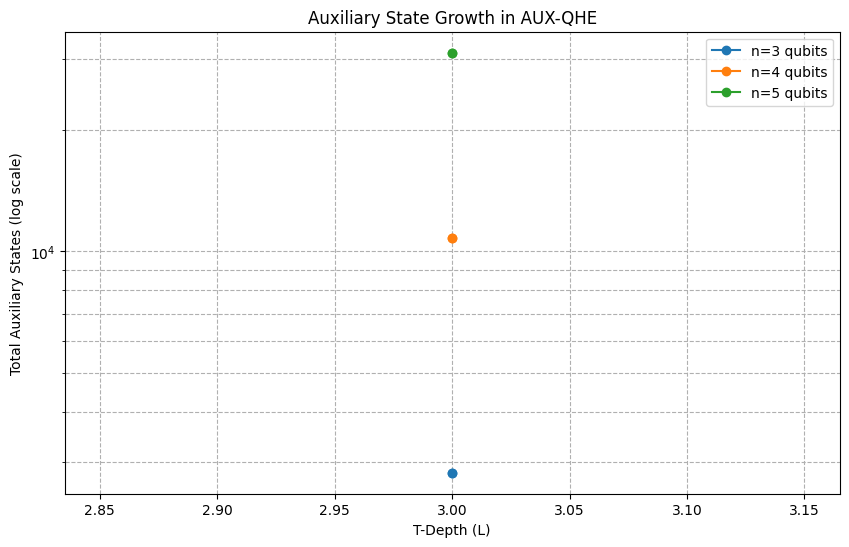

In [13]:
if __name__ == "__main__":
    qubit_range = [3,4,5]
    t_depth_range = [3]
    backend_name = "qgss-2025"
    shots = 4096
    prune_prob = 0.5  # If using optimized aux_keygen
    results, key_size_data = [], []

    params, encoder, encryptor, decryptor, evaluator = initialize_bfv_params(
        degree=8, plain_modulus=17, ciph_modulus=8000000000000
    )
    poly_degree = params.poly_degree

    # First, collect evaluation key size data for all configurations
    for num_qubits in qubit_range:
        for t_depth in t_depth_range:
            print(f"\n=== Computing Key Size for {num_qubits} Qubits, T-Depth {t_depth} ===")
            a_init = np.random.randint(0, 2, num_qubits).tolist()
            b_init = np.random.randint(0, 2, num_qubits).tolist()
            t_positions = [0] * num_qubits
            for layer in range(t_depth):
                qubit_idx = layer % num_qubits
                t_positions[qubit_idx] += 1

            _, _, aux_prep_time, layer_sizes, total_aux_states = aux_keygen(num_qubits, t_depth, a_init, b_init, t_positions)
            key_size_data.append({
                "num_qubits": num_qubits,
                "T-depth": t_depth,
                "layer_sizes": layer_sizes,
                "total_aux_states": total_aux_states,
                "aux_prep_time": aux_prep_time
            })

    # Generate test cases
    test_cases = generate_comprehensive_test_cases(qubit_range, t_depth_range)

    for case in test_cases:
        test_name = case['name']
        num_qubits = case['num_qubits']
        t_depth = case['t_depth']
        operations = case['operations']
        initial_state = case['initial_state']
        t_positions = case['t_positions']
        a_init = case['a_init']
        b_init = case['b_init']

        print(f"\n=== Testing {test_name} with {num_qubits} Qubits, T-Depth {t_depth} ===")
        
        # Initialize circuit with state
        qr = QuantumRegister(num_qubits, "q")
        qc_plain = QuantumCircuit(qr)
        initial_state_vec = Statevector.from_label(initial_state)
        qc_plain.initialize(initial_state_vec.data, qr)

        # Generate keys and auxiliary states 
        (a_init, b_init, k_dict), aux_states, aux_prep_time, layer_sizes, total_aux_states = aux_keygen(
            num_qubits, t_depth, a_init, b_init, t_positions
        )
        # Encrypt circuit 
        qc_encrypted, d, enc_a, enc_b = qotp_encrypt(
            qc_plain.copy(), a_init, b_init, 0, num_qubits + 1, encryptor, encoder, decryptor, poly_degree
        )
        if qc_encrypted is None:
            logger.error(f"Encryption failed for {test_name}")
            continue

        # Run test
        result = deploy_and_validate(
            qc_encrypted, a_init, b_init, operations, aux_states, t_positions, t_depth,
            backend_name=backend_name, shots=shots
        )
        (dec_circuit, decrypted_counts, expected_probs, fidelity, tvd, total_qubits,
         data_qubits, aux_qubits, additional_qubits, matched_qubits, total_qubits_with_symbolic,
         t_gadget_time, decrypt_eval_time, bfv_enc_time, bfv_dec_time) = result
        
        # Draw and save the decrypted circuit diagram
        diagram_filename = f"circuit_{test_name}.png"
        dec_circuit.draw(output='mpl')
        print(f"Saved circuit diagram for {test_name} as {diagram_filename}")
       
        # Compute overhead
        total_aux_overhead = aux_prep_time + t_gadget_time + decrypt_eval_time + bfv_enc_time + bfv_dec_time

        results.append({
            "num_qubits": num_qubits,
            "T-depth": t_depth,
            "fidelity": fidelity,
            "tvd": tvd,
            "matched_qubits": matched_qubits,
            "total_qubits_with_symbolic": total_qubits_with_symbolic,
            "total_qubits": total_qubits,
            "data_qubits": data_qubits,
            "aux_qubits": aux_qubits,
            "total_aux_states": total_aux_states,
            "aux_prep_time": aux_prep_time,
            "t_gadget_time": t_gadget_time,
            "decrypt_eval_time": decrypt_eval_time,
            "bfv_enc_time": bfv_enc_time,
            "bfv_dec_time": bfv_dec_time,
            "total_aux_overhead": total_aux_overhead,
        })

        key_size_data.append({
            "num_qubits": num_qubits,
            "T-depth": t_depth,
            "layer_sizes": [total_aux_states],
            "total_aux_states": total_aux_states,
            "aux_prep_time": aux_prep_time
        })

    # Table 1: Fidelity and Computational Overhead
    print("\n=== Table: Num Qubits, T-Depth vs. Fidelity and Computational Overhead ===")
    print("Test Name\t| Num Qubits\t| T-Depth\t| Fidelity\t| TVD\t\t| Aux Qubits\t| Total Aux States\t| Aux Prep Time (s)\t| T-Gadget Time (s)\t| Decrypt Eval Time (s)\t| BFV Enc Time (s)\t| BFV Dec Time (s)\t| Total Aux Overhead (s)")    
    print("-" * 18)
    for result in results:
        print(f"{result['num_qubits']:<12}| {result['T-depth']:<10}| {result['fidelity']:.4f}\t| {result['tvd']:.4f}\t| {result['aux_qubits']:<12}| {result['total_aux_states']:<18}| {result['aux_prep_time']:.4f}\t\t| {result['t_gadget_time']:.4f}\t\t| {result['decrypt_eval_time']:.4f}\t\t| {result['bfv_enc_time']:.4f}\t\t| {result['bfv_dec_time']:.4f}\t\t| {result['total_aux_overhead']:.4f}")
    # Table 2: Evaluation Key Size Analysis
    print("\n=== Table: Evaluation Key Size Analysis ===")
    print("Num Qubits\t| T-Depth\t| Layer Sizes\t| Total Aux States\t| Aux Prep Time (s)")
    print("-" * 100)
    for data in key_size_data:
        print(f"{data['num_qubits']:<12}| {data['T-depth']:<10}| {data['layer_sizes']}\t| {data['total_aux_states']:<18}| {data['aux_prep_time']:.4f}")

    # Save key size data to CSV
    df_key_size = pd.DataFrame(key_size_data)
    df_key_size.to_csv("aux_qhe_key_size_analysis.csv", index=False)

    # Plot auxiliary state growth
    plt.figure(figsize=(10, 6))
    for n in qubit_range:
        subset = [d for d in key_size_data if d['num_qubits'] == n]
        plt.plot([d['T-depth'] for d in subset], [d['total_aux_states'] for d in subset], marker='o', label=f'n={n} qubits')
    plt.yscale('log')
    plt.xlabel('T-Depth (L)')
    plt.ylabel('Total Auxiliary States (log scale)')
    plt.title('Auxiliary State Growth in AUX-QHE')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.savefig('aux_qhe_key_size_analysis.png')
    plt.show()

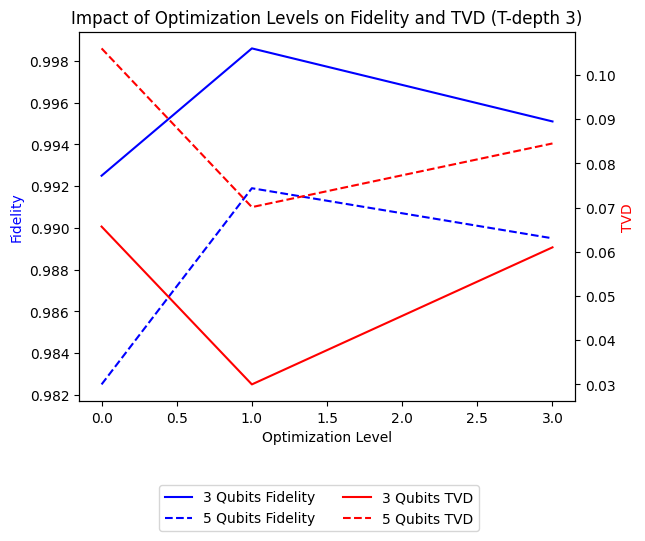

In [14]:
import matplotlib.pyplot as plt
levels = [0, 1, 3]
fidelity_3 = [0.9925, 0.9986, 0.9951]
fidelity_5 = [0.9825, 0.9919, 0.9895]
tvd_3 = [0.0657, 0.0300, 0.0610]
tvd_5 = [0.1060, 0.0701, 0.0845]
fig, ax1 = plt.subplots()
ax1.plot(levels, fidelity_3, 'b-', label='3 Qubits Fidelity')
ax1.plot(levels, fidelity_5, 'b--', label='5 Qubits Fidelity')
ax1.set_xlabel('Optimization Level')
ax1.set_ylabel('Fidelity', color='b')
ax2 = ax1.twinx()
ax2.plot(levels, tvd_3, 'r-', label='3 Qubits TVD')
ax2.plot(levels, tvd_5, 'r--', label='5 Qubits TVD')
ax2.set_ylabel('TVD', color='r')
plt.title('Impact of Optimization Levels on Fidelity and TVD (T-depth 3)')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.show()

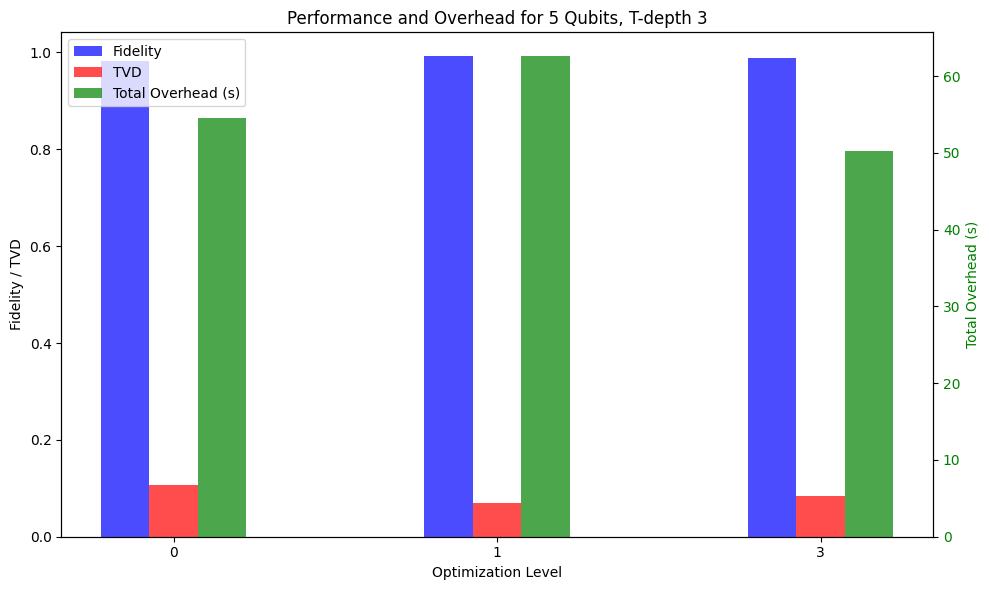

In [1]:
import matplotlib.pyplot as plt

levels = [0, 1, 3]
fidelity = [0.9825, 0.9919, 0.9895]
tvd = [0.1060, 0.0701, 0.0845]
overhead = [54.4870, 62.5761, 50.2009]

bar_width = 0.3
x = range(len(levels))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot fidelity and TVD on left y-axis
ax1.bar([i - bar_width/2 for i in x], fidelity, width=bar_width/2, 
        color='b', alpha=0.7, label='Fidelity')
ax1.bar([i for i in x], tvd, width=bar_width/2, 
        color='r', alpha=0.7, label='TVD')
ax1.set_xlabel('Optimization Level')
ax1.set_ylabel('Fidelity / TVD', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create second y-axis for overhead
ax2 = ax1.twinx()
ax2.bar([i + bar_width/2 for i in x], overhead, width=bar_width/2, 
        color='g', alpha=0.7, label='Total Overhead (s)')
ax2.set_ylabel('Total Overhead (s)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

plt.title('Performance and Overhead for 5 Qubits, T-depth 3')
ax1.set_xticks(x)
ax1.set_xticklabels(levels)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

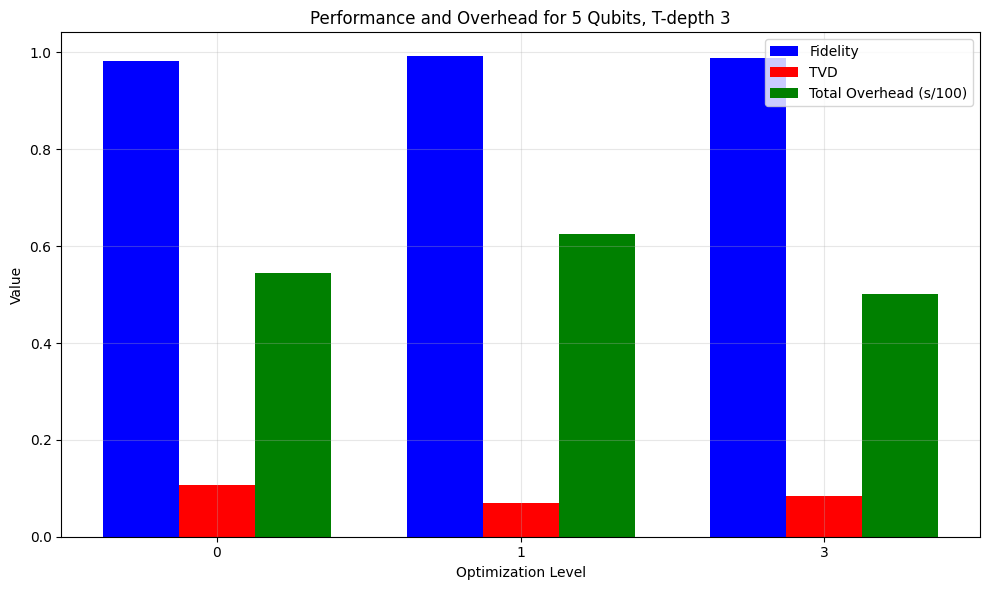

In [2]:
import matplotlib.pyplot as plt

levels = [0, 1, 3]
fidelity = [0.9825, 0.9919, 0.9895]
tvd = [0.1060, 0.0701, 0.0845]
overhead = [54.4870, 62.5761, 50.2009]

bar_width = 0.25
r1 = range(len(levels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(r1, fidelity, color='b', width=bar_width, label='Fidelity')
plt.bar(r2, tvd, color='r', width=bar_width, label='TVD')

# Scale overhead to make it visible (divide by 100)
overhead_scaled = [x/100 for x in overhead]
plt.bar(r3, overhead_scaled, color='g', width=bar_width, label='Total Overhead (s/100)')

plt.xlabel('Optimization Level')
plt.ylabel('Value')
plt.title('Performance and Overhead for 5 Qubits, T-depth 3')

# Center the x-ticks properly
plt.xticks([r + bar_width for r in range(len(levels))], levels)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from qiskit.quantum_info import hellinger_fidelity
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2
from scipy.stats import wasserstein_distance
import numpy as np

def analyze_errors_and_mitigate(circuit, enc_a, enc_b, aux_states, max_t_depth, encryptor, decryptor, encoder, poly_degree, t_positions, backend, debug=True):
    """
    Analyze errors and apply ZNE mitigation for the FHE-AUX-QHE evaluated circuit.

    Args:
        circuit (QuantumCircuit): Input circuit from aux_eval.
        enc_a, enc_b (list): Encrypted QOTP keys.
        aux_states (dict): Auxiliary states.
        max_t_depth (int): Maximum T-depth.
        encryptor, decryptor, encoder: BFV components.
        poly_degree (int): BFV polynomial degree.
        t_positions (list): T-gate counts per qubit.
        backend: IBM Quantum backend (e.g., ibm_torino).
        debug (bool): Enable debug logging.

    Returns:
        dict: Results with ideal, noisy, and mitigated probabilities, fidelity, TVD, and error reduction.
    """
    results = {}
    
    # Step 1: Run aux_eval to get evaluated circuit
    logger.info("Running aux_eval for error analysis")
    eval_circuit, new_enc_a, new_enc_b = aux_eval(
        circuit, enc_a, enc_b, aux_states, max_t_depth, encryptor, decryptor, encoder, poly_degree, t_positions, debug
    )
    
    # Step 2: Transpile with optimization_level=1
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    transpiled_circuit = pm.run(eval_circuit)
    
    # Step 3: Ideal simulation with AerSimulator
    ideal_simulator = AerSimulator(method='statevector')
    ideal_sampler = Sampler(mode=ideal_simulator)
    ideal_job = ideal_sampler.run([(transpiled_circuit, None)], shots=4096)
    ideal_counts = ideal_job.result()[0].data.get('meas_aux_0_0', {}).get_counts()
    if not ideal_counts:
        ideal_counts = ideal_job.result()[0].data.get(list(ideal_job.result()[0].data.keys())[0]).get_counts()
    ideal_probs = {k: v / 4096 for k, v in ideal_counts.items()}
    results['ideal_probs'] = ideal_probs
    logger.info(f"Ideal probabilities: {ideal_probs}")
    
    # Step 4: Case 1 - No error mitigation (full noise impact)
    options_no_mitigation = {
        "optimization_level": 1,
        "resilience": {
            "zne": {"enabled": False},
            "twirled_readout_error_mitigation": {"enabled": False}
        },
        "execution": {"shots": 4096}
    }
    sampler_no_mitigation = Sampler(mode=backend, options=options_no_mitigation)
    job_no_mitigation = sampler_no_mitigation.run([(transpiled_circuit, None)])
    counts_no_mitigation = job_no_mitigation.result()[0].data.get(list(job_no_mitigation.result()[0].data.keys())[0]).get_counts()
    probs_no_mitigation = {k: v / 4096 for k, v in counts_no_mitigation.items()}
    results['no_mitigation_probs'] = probs_no_mitigation
    fidelity_no_mitigation = hellinger_fidelity(ideal_probs, probs_no_mitigation)
    tvd_no_mitigation = 0.5 * sum(abs(ideal_probs.get(k, 0) - probs_no_mitigation.get(k, 0)) for k in set(ideal_probs) | set(probs_no_mitigation))
    results['no_mitigation_fidelity'] = fidelity_no_mitigation
    results['no_mitigation_tvd'] = tvd_no_mitigation
    logger.info(f"No mitigation: fidelity={fidelity_no_mitigation:.4f}, TVD={tvd_no_mitigation:.4f}")
    
    # Step 5: Run NoiseLearner for noise model
    learner = NoiseLearner(mode=backend, options={
        "max_layers_to_learn": max_t_depth,
        "num_randomizations": 16,
        "twirling_strategy": "active"
    })
    job_learner = learner.run([transpiled_circuit])
    noise_model = job_learner.result()
    
    # Step 6: Case 2 - With ZNE mitigation
    options_zne = {
        "optimization_level": 1,
        "resilience": {
            "zne": {
                "enabled": True,
                "noise_factors": [1, 1.5, 2],
                "extrapolator": "linear",
                "noise_model": noise_model
            },
            "twirled_readout_error_mitigation": {"enabled": False}
        },
        "execution": {"shots": 4096}
    }
    sampler_zne = Sampler(mode=backend, options=options_zne)
    job_zne = sampler_zne.run([(transpiled_circuit, None)])
    counts_zne = job_zne.result()[0].data.get(list(job_zne.result()[0].data.keys())[0]).get_counts()
    probs_zne = {k: v / 4096 for k, v in counts_zne.items()}
    results['zne_probs'] = probs_zne
    fidelity_zne = hellinger_fidelity(ideal_probs, probs_zne)
    tvd_zne = 0.5 * sum(abs(ideal_probs.get(k, 0) - probs_zne.get(k, 0)) for k in set(ideal_probs) | set(probs_zne))
    results['zne_fidelity'] = fidelity_zne
    results['zne_tvd'] = tvd_zne
    logger.info(f"ZNE: fidelity={fidelity_zne:.4f}, TVD={tvd_zne:.4f}")
    
    # Step 7: Quantify improvement
    fidelity_improvement = (fidelity_zne - fidelity_no_mitigation) / (1 - fidelity_no_mitigation) * 100 if fidelity_no_mitigation < 1 else 0
    tvd_reduction = (tvd_no_mitigation - tvd_zne) / tvd_no_mitigation * 100 if tvd_no_mitigation > 0 else 0
    results['fidelity_improvement_percent'] = fidelity_improvement
    results['tvd_reduction_percent'] = tvd_reduction
    logger.info(f"Improvement: fidelity increased by {fidelity_improvement:.2f}%, TVD reduced by {tvd_reduction:.2f}%")
    
    return results

# Example usage in your test loop (add after your existing test_comprehensive_q5_t3)
def run_comprehensive_test_with_error_analysis(num_qubits=5, t_depth=3):
    logger.info(f"Running comprehensive test with error analysis: {num_qubits} qubits, T-depth {t_depth}")
    
    # Existing setup from your code
    params, encoder, encryptor, decryptor, evaluator = initialize_bfv_params()
    poly_degree = params.poly_degree
    circuit = QuantumCircuit(num_qubits)
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.t(0)
    circuit.t(1)
    circuit.cx(1, 2)
    circuit.t(2)
    circuit.measure_all()
    
    a_init = [random.randint(0, 1) for _ in range(num_qubits)]
    b_init = [random.randint(0, 1) for _ in range(num_qubits)]
    t_positions = [1] * num_qubits  # Adjust based on circuit
    secret_key, aux_states, aux_prep_time, layer_sizes, total_aux_states = aux_keygen(
        num_qubits, t_depth, a_init, b_init, t_positions
    )
    enc_circuit, d, enc_a, enc_b = qotp_encrypt(
        circuit, a_init, b_init, 0, num_qubits, encryptor, encoder, decryptor, poly_degree
    )
    
    # Run error analysis
    error_results = analyze_errors_and_mitigate(
        enc_circuit, enc_a, enc_b, aux_states, t_depth, encryptor, decryptor, encoder, poly_degree, t_positions, backend
    )
    
    # Update results table
    test_name = f"test_comprehensive_q{num_qubits}_t{t_depth}"
    results_table = {
        'Test Name': test_name,
        'Num Qubits': num_qubits,
        'T-Depth': t_depth,
        'Fidelity (No Mitigation)': error_results['no_mitigation_fidelity'],
        'TVD (No Mitigation)': error_results['no_mitigation_tvd'],
        'Fidelity (ZNE)': error_results['zne_fidelity'],
        'TVD (ZNE)': error_results['zne_tvd'],
        'Fidelity Improvement (%)': error_results['fidelity_improvement_percent'],
        'TVD Reduction (%)': error_results['tvd_reduction_percent'],
        'Aux Qubits': num_qubits,
        'Total Aux States': total_aux_states,
        'Aux Prep Time (s)': aux_prep_time
    }
    logger.info(f"Error analysis results: {results_table}")
    
    return results_table

# Run the test
if __name__ == "__main__":
    test_results = run_comprehensive_test_with_error_analysis()
    print(pd.DataFrame([test_results]).to_string(index=False))